# The purpose of this notebook

This is the final notebook that makes figures for the paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
np.set_printoptions(precision=3)

import pandas as pd

import scipy.stats as st
import statsmodels.stats.multitest as mt

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

import suppression as s
import utils

In [4]:
n_boot = 10000
np.random.seed(123)

In [5]:
#gaba_fn = 'gaba_data_2019.txt'
gaba_fn = 'gaba_data_2021.txt'
supp_fn = 'supp_data_individual_20170427.txt'

sdf = utils.load_psychophys(supp_fn)
gaba_col = 'mean_occ_all'
#gaba_col = 'occ_binoc'
gdf = utils.load_gaba(gaba_fn, gaba_col)
gdf_motor = utils.load_gaba(gaba_fn, 'motor')

In [6]:
def categorize(df, col, values=None):
    df[col] = df[col].astype("category")
    if values is not None:
        if len(values)==len(df[col].cat.categories):
            df[col].cat.rename_categories(values, inplace=True)
            df[col].cat.reorder_categories(values.values(), inplace=True)
    return df

pop_dict = {'Amblyope':'PWA', 'Control':'NSP'}

gdf = categorize(gdf, 'Population', pop_dict)
sdf = categorize(sdf, 'Population', pop_dict)

print(gdf.Population.cat.categories)

Index(['PWA', 'NSP'], dtype='object')


/home/smerdis/anaconda3/envs/amblyopia/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_89444/2661607495.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df[col].cat.reorder_categories(values.values(), inplace=True)
/home/smerdis/anaconda3/envs/amblyopia/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/i

In [7]:
demos = pd.read_csv('demos.csv', lineterminator="\r")
demos['motorGABA'] = demos['motorGABA'].astype('float')
# 1 = amb, 0 = control
subs_to_swap_eyes = demos[demos.swapNDE_EY==1].initials.unique() # subjects whose NDE/DE assignment is wrong in sdf
print(subs_to_swap_eyes)

['ai' 'ct' 'dl' 'ei' 'kw' 'nl']


### Set variables used for graphing

In [8]:
colors2 = {'PWA':'#2f87c4', 'NSP':'#ff7f0e'}
colors_amb = ["#3274a1","#72b4e1"]
colors_con = ["#e1812c", "#ffc68c"]
colors4 = colors_amb + colors_con
# grayscale color palette for publication
grey4 = ["#333333", "#999999", "#333333", "#999999"] # same set for PWA and NSP, NDE=light, DE=dark
traces4 = ['Amblyope-De', 'Amblyope-Nde', 'Control-De', 'Control-Nde']
traces_graph4 = [f"Persons with\nAmblyopia, DE", f"Persons with\nAmblyopia, NDE", \
                 f"Normally-sighted\npersons, DE", f"Normally-sighted\npersons, NDE"]
pal4 = {}
pal4g = {}
pal4ggrey = {}
for t, c in zip(traces4, colors4):
    pal4[t] = c
for t, c in zip(traces_graph4, colors4):
    pal4g[t] = c
for t, c in zip(traces_graph4, grey4):
    pal4ggrey[t] = c
print(pal4, pal4g, sep='\n')
plot_dir = f"plots/frontiers-onoff-postreview"

{'Amblyope-De': '#3274a1', 'Amblyope-Nde': '#72b4e1', 'Control-De': '#e1812c', 'Control-Nde': '#ffc68c'}
{'Persons with\nAmblyopia, DE': '#3274a1', 'Persons with\nAmblyopia, NDE': '#72b4e1', 'Normally-sighted\npersons, DE': '#e1812c', 'Normally-sighted\npersons, NDE': '#ffc68c'}


### Demographic information

In [9]:
nsp_demos = demos[demos['group']==0].copy()
np.count_nonzero(nsp_demos.labelSex=='female')

6

### Figure 7: GABA vs depth of amblyopia

In [10]:
iad_plot_df = demos.join(gdf.set_index(['subjName'])['GABA'], on=['initials'])
iad_motor_df = demos.join(gdf_motor.set_index(['subjName'])['GABA'], on=['initials'])

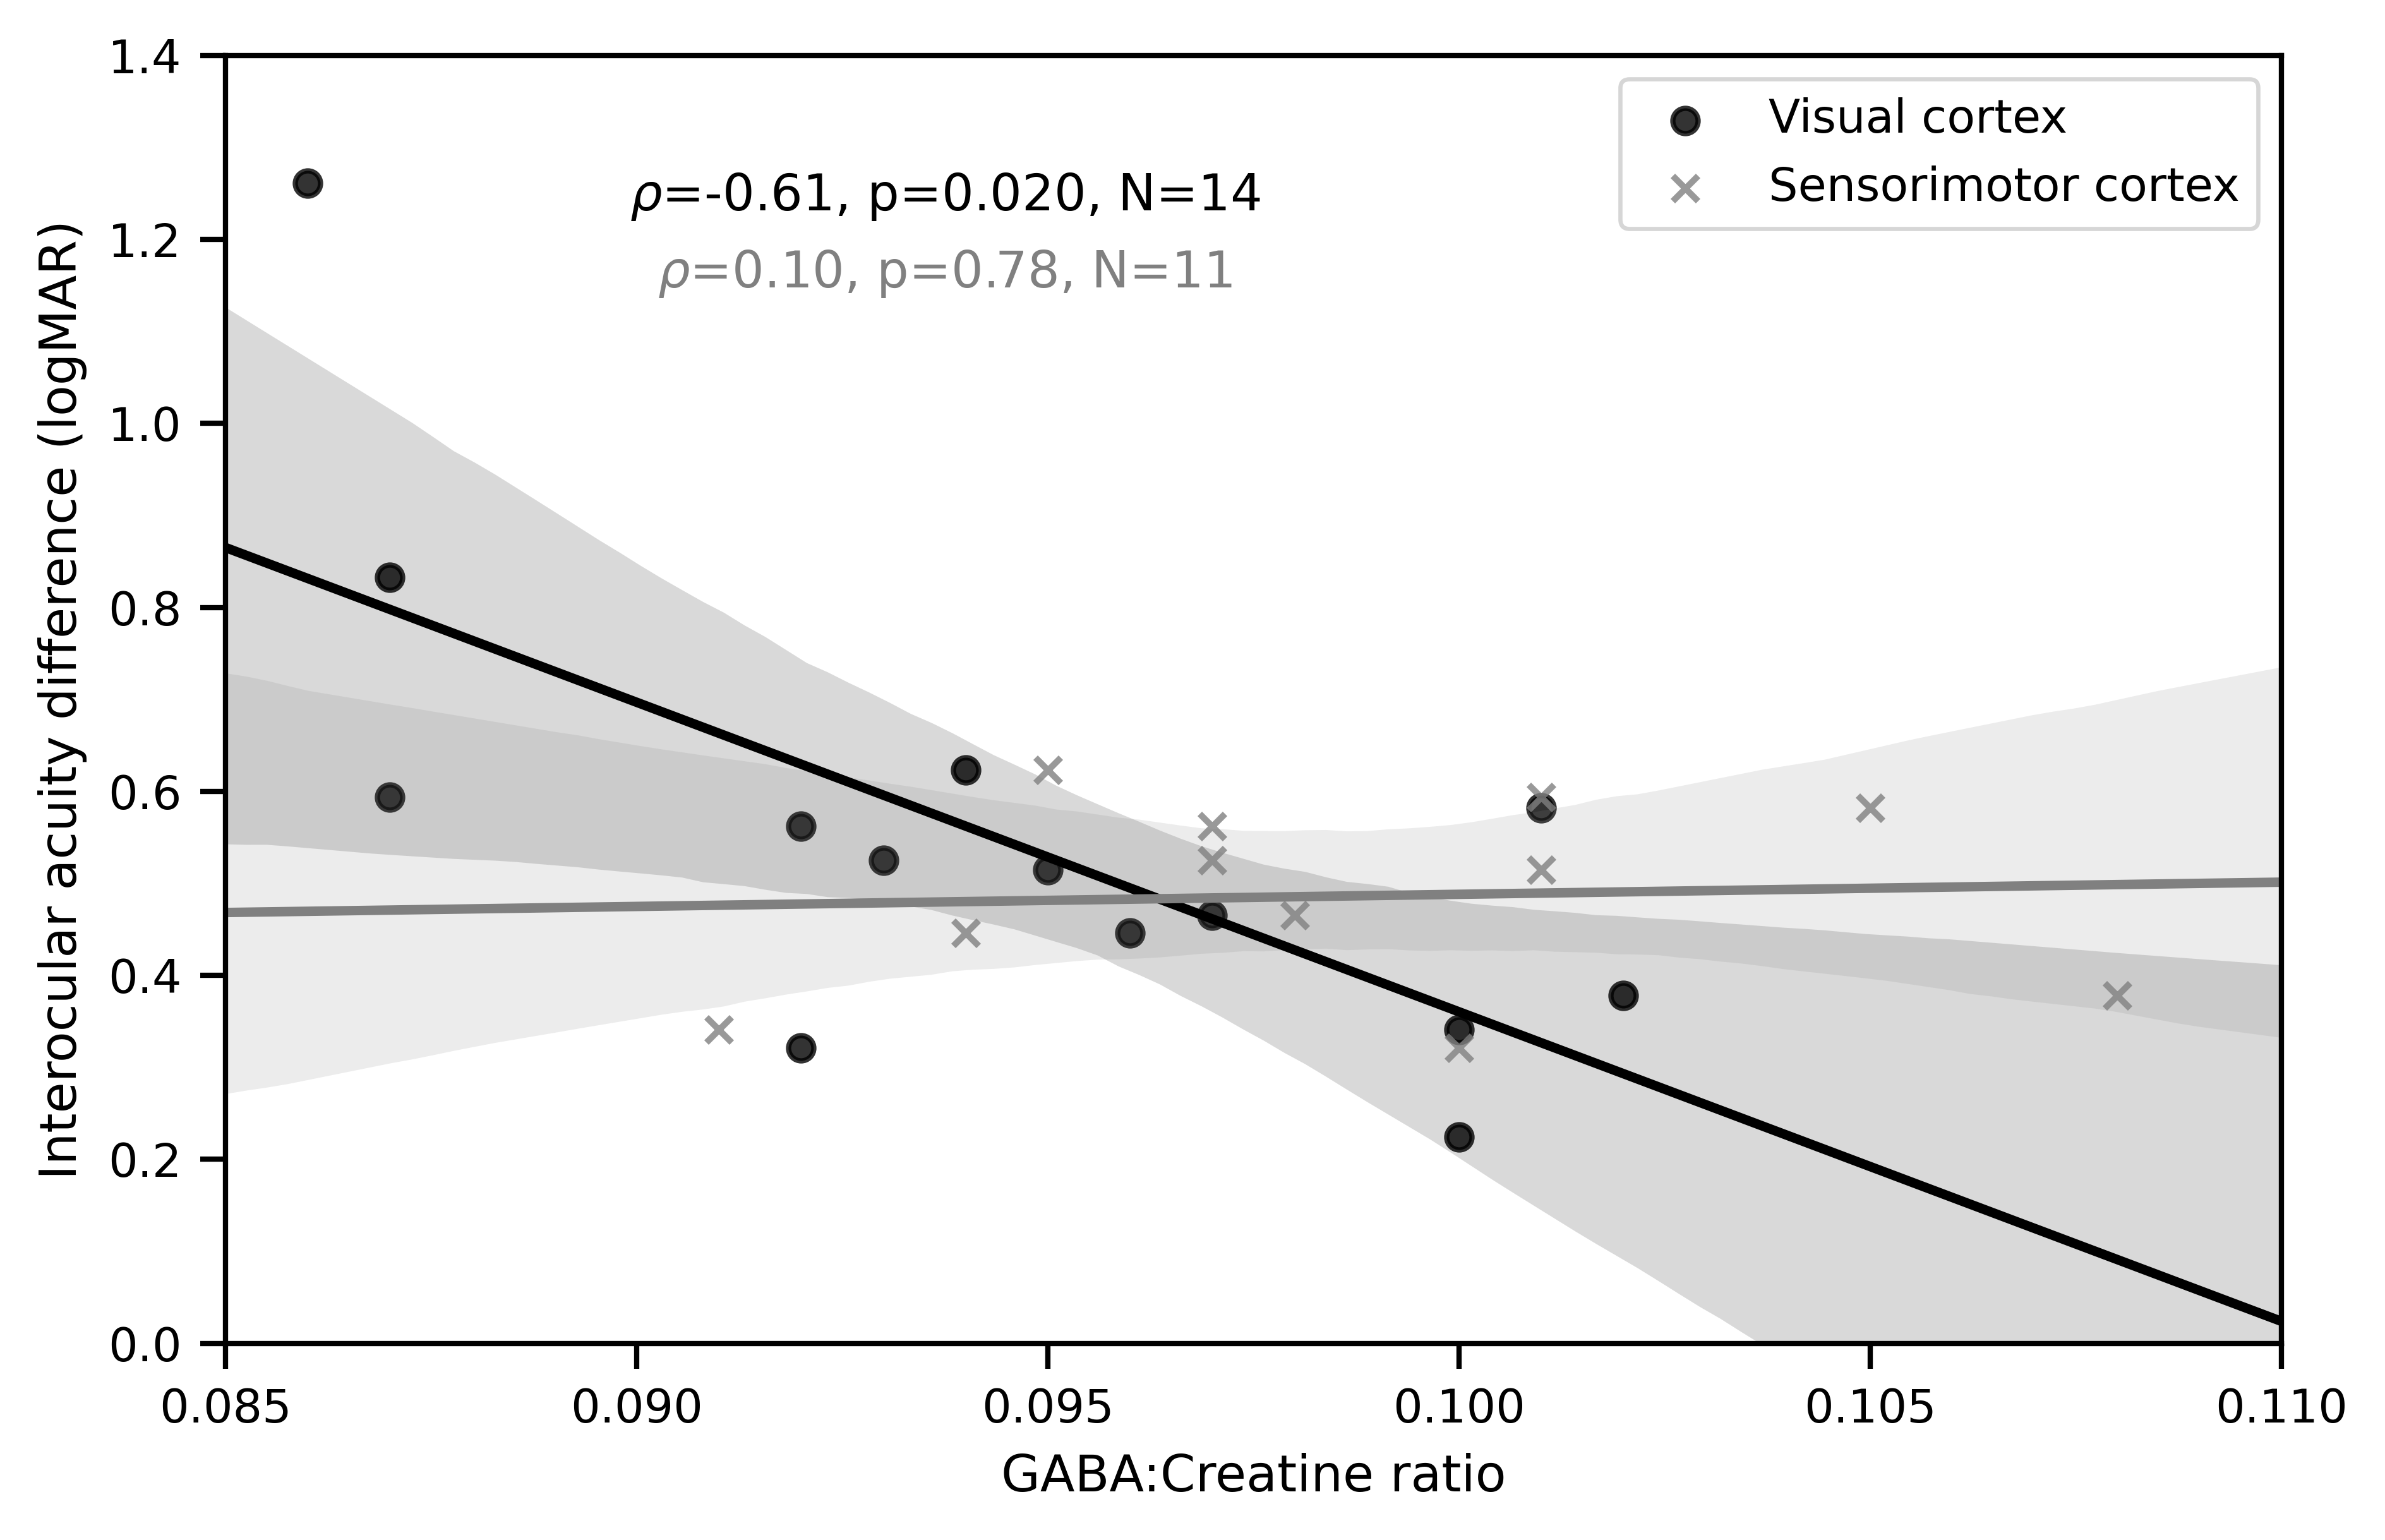

In [11]:
with sns.plotting_context(context="paper", font_scale=1.0):
    amb_data = iad_plot_df[iad_plot_df['group']==1].copy()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4.5))
    ax.set_xlim(0.085, 0.11)
    ax.set_ylim(0, 1.4)
    
    sns.regplot(data=amb_data, x='GABA', y='iadLogMAR', color='black', marker='o', ax=ax, label='Visual cortex', truncate=False)
    r, p = st.spearmanr(amb_data['GABA'], amb_data['iadLogMAR'])
    ax.text(.35, 0.88, f"$\\rho$={r:.2f}, p={p:.3f}, N={len(amb_data['occGABA'].dropna())}", transform=ax.transAxes, fontdict={'color': 'black'}, horizontalalignment='center')
    
    amb_data_motor = iad_motor_df[iad_motor_df['group']==1].copy()
    has_motor = amb_data_motor[~np.isnan(amb_data_motor['GABA'])]
    sns.regplot(data=amb_data_motor, x='GABA', y='iadLogMAR', color='grey', marker='x', ax=ax, label='Sensorimotor cortex', truncate=False)
    r, p = st.spearmanr(has_motor['GABA'], has_motor['iadLogMAR'])
    ax.text(.35, 0.82, f"$\\rho$={r:.2f}, p={p:.2f}, N={len(amb_data_motor['GABA'].dropna())}", transform=ax.transAxes, fontdict={'color': 'grey'}, horizontalalignment='center')

    ax.legend()
    ax.set_xlabel("GABA:Creatine ratio")
    ax.set_ylabel("Interocular acuity difference (logMAR)")
    fig.set_dpi(600)
    fig.savefig(f"{plot_dir}/figure_07.pdf", dpi='figure')
    plt.show()
    plt.close('all')

In [12]:
print("occ gaba vs IAD: ", st.spearmanr(amb_data['GABA'], amb_data['iadLogMAR']))
print("motor gaba vs IAD: ", st.spearmanr(has_motor['GABA'], has_motor['iadLogMAR']))

occ gaba vs IAD:  SpearmanrResult(correlation=-0.6130132760962298, pvalue=0.01975081405131035)
motor gaba vs IAD:  SpearmanrResult(correlation=0.09589141064521686, pvalue=0.77912326201205)


## Analyze tasks separately (before subsetting to include common subjects)

In [13]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em'
 'es' 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv'
 'nl' 'nn' 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd'
 'gm' 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn'
 'sd' 'tt' 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

#### Remove AM and TT due to bad data

In [14]:
gdf_reduced = gdf[(gdf.subjName != 'am') & (gdf.subjName !='tt')]
pop_group_reduced = gdf_reduced.groupby("Population")
gaba_per_group = [col for col_name, col in pop_group_reduced['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-0.7521449188296094 0.4584712277007398


In [15]:
gdf = gdf_reduced.copy()
gaba_df_immutable = gdf_reduced.copy()
gaba_df_immutable.groupby("Population").describe() # Shoud be 14 PWA due to AM, TT exclusion

GABA                                                           
           count      mean       std    min     25%     50%      75%    max
Population                                                                 
PWA         14.0  0.094429  0.005316  0.086  0.0920  0.0945  0.09925  0.102
NSP         15.0  0.095733  0.003973  0.090  0.0925  0.0950  0.09800  0.103

In [16]:
gaba_df_immutable.groupby("Population").sem() # Shoud be 14 PWA due to AM, TT exclusion

,GABA
Population,
PWA,0.001421
NSP,0.001026


In [17]:
gaba_df_immutable['GABA_rank'] = gaba_df_immutable.groupby(["Population"])['GABA'].rank(method='max').astype(int)

In [18]:
gaba_df_immutable.subjName.unique()

array(['ac', 'as', 'bi', 'ch', 'cs', 'em', 'gd', 'jv', 'ks', 'li', 'mg',
       'ps', 'rn', 'sd', 'ai', 'cr', 'ct', 'dl', 'ei', 'es', 'gm', 'jd',
       'jm', 'kw', 'ls', 'mk', 'ms', 'nl', 'yl'], dtype=object)

## Figure 6: GABA concentrations

In [19]:
colors = sns.color_palette()
colors[:2]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

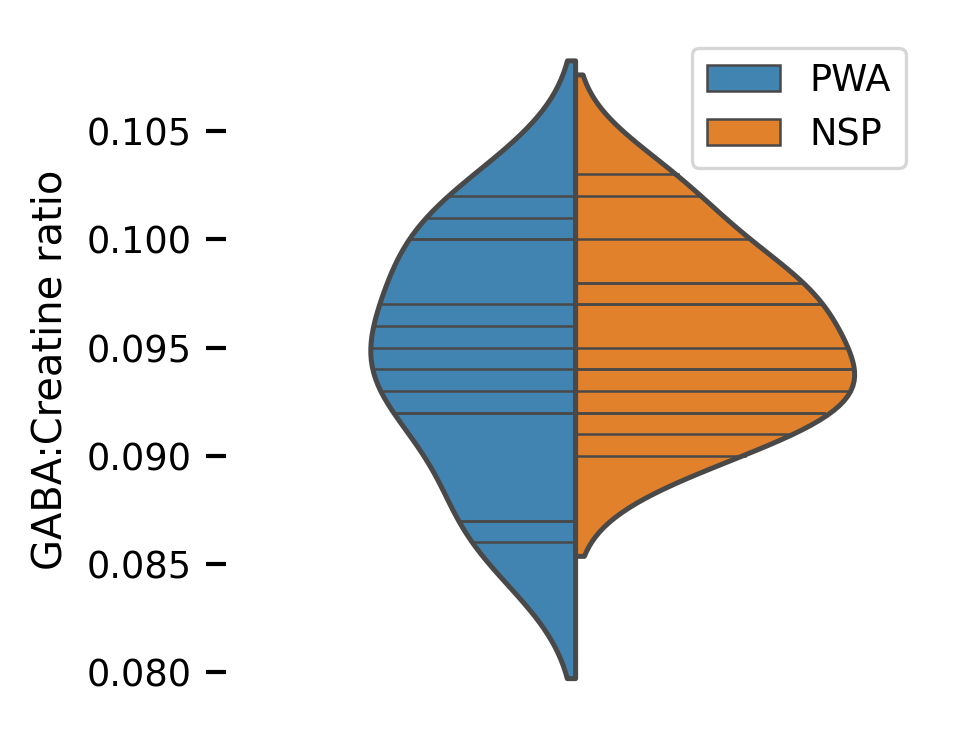

In [20]:
with sns.plotting_context(context="paper", font_scale=1.0):
    fig = plt.figure(figsize=(3,3))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    g = sns.violinplot(x='Presentation', y='GABA', hue='Population', data=gaba_df_immutable,
                    ax=ax, palette=colors2, split=True, inner='stick')
    ax.legend(loc=1)
    ax.xaxis.set_visible(False)
    ax.set_ylabel('GABA:Creatine ratio')
    sns.despine(left=True, bottom=True, right=True)
    #ax.set_yticklabels([])
    ax.figure.set_dpi(300)
    ax.figure.savefig(f"{plot_dir}/figure_06.pdf")
    plt.show()
    plt.close('all')

# Select one psychophysical task's data #

In [21]:
task = 'SS' # surround suppression task
sdf = sdf[sdf['Task']==task]
df_to_model = sdf.copy(deep=True) # make a deep copy

n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
amb_subjs = np.unique(df_to_model[df_to_model["Population"]=="PWA"]["Subject"])
print(amb_subjs)
n_amb_subjs_thistask = len(amb_subjs)
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

['ah' 'am' 'bi' 'cl' 'eg' 'em' 'gd' 'jv' 'li' 'mg' 'mv' 'rn' 'sd']
There are 35 subjects for Task SS, of which 13 are Amblyopes.


### Baseline contrast discrimination thresholds

In [22]:
onecond = df_to_model[(df_to_model['Presentation']=='nMono') & (df_to_model['Orientation']=='Iso')]
cnde_subs = onecond[onecond['Trace']=='Control-Nde'].Subject.unique()
cde_subs = onecond[onecond['Trace']=='Control-De'].Subject.unique()
thresh_noswap = onecond.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace','Subject'], as_index=False)['BaselineThresh'].mean().dropna()
eye_counts = thresh_noswap['Subject'].value_counts().reset_index()
nounpaired = (eye_counts[eye_counts.Subject==2])['index'].unique()
thresh_noswap_nounpaired = thresh_noswap[thresh_noswap['Subject'].isin(nounpaired)]
thresh_noswap_nounpaired.groupby(['Trace']).describe()

BaselineThresh                                              \
                      count      mean       std    min      25%     50%   
Trace                                                                     
Amblyope-De            13.0  6.136462  1.280663  4.063  5.94900  6.2620   
Amblyope-Nde           13.0  7.318385  2.364243  4.558  5.94400  6.7870   
Control-De             16.0  6.309750  1.559247  4.033  5.42650  6.0295   
Control-Nde            16.0  5.921750  1.467759  3.124  5.20325  5.6900   

                               
                  75%     max  
Trace                          
Amblyope-De   6.82600   7.827  
Amblyope-Nde  7.83400  13.226  
Control-De    6.90475   9.987  
Control-Nde   6.68325   8.794

### Assign NDE/DE purely via baseline contrast discrimination

In [23]:
subs_to_swap_eyes_baselineSS = []
for gv, g in thresh_noswap_nounpaired.groupby(['Subject']):
    nde_thresh = g[g.Eye=='Nde']['BaselineThresh'].iloc[0]
    de_thresh = g[g.Eye=='De']['BaselineThresh'].iloc[0]
    diff = nde_thresh - de_thresh
    is_nsp = np.all(g['Population']=='NSP')
    if is_nsp and diff < 0:
        print(f"Participant {gv} has a lower threshold in Nde than De but is a NSP, will swap.")
        subs_to_swap_eyes_baselineSS.append(g.Subject.iloc[0])

Participant ai has a lower threshold in Nde than De but is a NSP, will swap.
Participant cr has a lower threshold in Nde than De but is a NSP, will swap.
Participant ct has a lower threshold in Nde than De but is a NSP, will swap.
Participant dl has a lower threshold in Nde than De but is a NSP, will swap.
Participant ei has a lower threshold in Nde than De but is a NSP, will swap.
Participant gm has a lower threshold in Nde than De but is a NSP, will swap.
Participant jd has a lower threshold in Nde than De but is a NSP, will swap.
Participant kw has a lower threshold in Nde than De but is a NSP, will swap.
Participant ls has a lower threshold in Nde than De but is a NSP, will swap.
Participant ms has a lower threshold in Nde than De but is a NSP, will swap.
Participant se has a lower threshold in Nde than De but is a NSP, will swap.
Participant tm has a lower threshold in Nde than De but is a NSP, will swap.
Participant yl has a lower threshold in Nde than De but is a NSP, will swap.

In [24]:
def swap_eyevars(df, subs):
    if df['Subject'] in subs: # fix here
        if df['Eye'] == "De":
            df['Eye'] = "Nde"
            df['Trace'] = df['Trace'].replace('-De', '-Nde')
        else:
            df['Eye'] = "De"
            df['Trace'] = df['Trace'].replace('-Nde', '-De')
    return df

def fix_eyes(df):
    disp_cols = ['Subject','Eye','Trace','BaselineThresh']
    # Identify which rows are of subjects that should be swapped
    # Changed 6/18/21 to include the possibility of assigning eyes based on baseline surround suppression
    subs_to_swap_eyes = subs_to_swap_eyes_baselineSS # assign NSP eyes purely based on baselineSS, disregarding swapNde_EY etc.
    rows_to_change = df_to_model[df_to_model.Subject.isin(subs_to_swap_eyes)]
    assert(np.all(rows_to_change.Population == 'NSP')) # should only affect controls
    assert(np.all(rows_to_change.Trace.isin(['Control-De','Control-Nde']))) # these should be swapped along w/ Eye
    fixed = df.apply(swap_eyevars, subs=subs_to_swap_eyes, axis=1)
    return fixed

df_to_model_fixeyes = fix_eyes(df_to_model)

In [25]:
df_to_model_fixeyes.groupby("Trace")['BaselineThresh'].describe()

,count,mean,std,min,25%,50%,75%,max
Trace,,,,,,,,
Amblyope-De,208.0,6.170423,1.226235,4.063,5.949,6.262,6.826,7.827
Amblyope-Nde,204.0,7.228000,2.152685,4.558,5.944,6.787,7.834,13.226
Control-De,216.0,5.826167,1.357432,3.124,4.985,5.552,6.405,8.794
Control-Nde,342.0,6.174883,1.385176,4.033,5.205,5.741,6.745,9.987


### Toggle which version of the data to use, "fixed" eyes or not

In [26]:
df_to_model = df_to_model_fixeyes

### Begin grouping data into conditions to model Subject's ThreshElev as a function of MaskContrast

In [27]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

groups_with_baseline = df_to_model.groupby(pp_gvars_base)

# Check if there are any conditions with only two data points
for gv, gr in groups_with_baseline:
    if len(gr)<=2:
        print(gv, gr)

## BaselineThresh analysis before modeling

In [28]:
thresh_swap = df_to_model.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'Subject','Eye', 'Trace'])['BaselineThresh'].mean().reset_index()
thresh_swap = thresh_swap[(thresh_swap.Orientation=="Iso")&(thresh_swap.Presentation=='nDicho')]
eye_counts_swap = thresh_swap.Subject.value_counts()
subs_no_unpaired = eye_counts[eye_counts_swap.reset_index()['Subject']==2]['index'].unique()
print(subs_no_unpaired, len(subs_no_unpaired))

['ah' 'ct' 'yl' 'tm' 'se' 'nl' 'ms' 'mk' 'ls' 'kw' 'jd' 'gm' 'es' 'am'
 'dl' 'ei' 'cr' 'jv' 'bi' 'cl' 'eg' 'ai' 'gd' 'em' 'li' 'mg' 'mv' 'rn'
 'sd'] 29


In [29]:
thresh_swap_nounpaired = thresh_swap[thresh_swap.Subject.isin(subs_no_unpaired)]

### Calculate differences, ratios etc for each subject

In [30]:
baseline_df_withinsubject = thresh_swap.groupby(#thresh_swap_nounpaired.groupby(
                                        ['Task', 'Orientation', 'Presentation', 'Population',
                                        'Subject']).apply(utils.get_interocular_diff, 'BaselineThresh')
baseline_df_withinsubject.rename(columns={'ValueDiff':'BaselineDiff', 'ValueRatio':'BaselineRatio'}, inplace=True)
baseline_df_withinsubject[(baseline_df_withinsubject.Population=="PWA") & (baseline_df_withinsubject.Eye=="De")]

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,BaselineDiff,BaselineRatio
166,SS,Iso,nDicho,PWA,ah,De,Amblyope-De,7.590,-3.032,0.600527
168,SS,Iso,nDicho,PWA,am,De,Amblyope-De,7.532,0.302,1.040096
170,SS,Iso,nDicho,PWA,bi,De,Amblyope-De,7.827,2.314,1.295643
172,SS,Iso,nDicho,PWA,cl,De,Amblyope-De,6.709,0.749,1.111641
174,SS,Iso,nDicho,PWA,eg,De,Amblyope-De,6.826,-0.039,0.994287
176,SS,Iso,nDicho,PWA,em,De,Amblyope-De,5.949,0.065,1.010926
178,SS,Iso,nDicho,PWA,gd,De,Amblyope-De,6.210,0.326,1.052496
180,SS,Iso,nDicho,PWA,jv,De,Amblyope-De,4.227,0.537,1.127040
182,SS,Iso,nDicho,PWA,li,De,Amblyope-De,4.063,3.253,1.800640
184,SS,Iso,nDicho,PWA,mg,De,Amblyope-De,4.174,1.480,1.354576


In [31]:
baseline_df_withinsubject_diffs = baseline_df_withinsubject.groupby(['Population','Subject'], as_index=False)[['BaselineDiff','BaselineRatio']].mean()
baseline_df_withinsubject_diffs = categorize(baseline_df_withinsubject_diffs, 'Population', {'PWA':'PWA','NSP':'NSP'})

/home/smerdis/anaconda3/envs/amblyopia/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_89444/2661607495.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df[col].cat.reorder_categories(values.values(), inplace=True)


###  Exclude subject 'ah' based on being a HUGE outlier

In [32]:
adiff = baseline_df_withinsubject_diffs[(baseline_df_withinsubject_diffs.Population=="PWA") &
                                        (baseline_df_withinsubject_diffs.Subject!="ah")].dropna()
cdiff = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Population=="NSP"].dropna()

In [33]:
print(adiff, cdiff, sep='\n')
print("PWA NDE/DE != 1:", st.ttest_1samp(adiff['BaselineRatio'], popmean=1))
print("NSP NDE/DE != 1:", st.ttest_1samp(cdiff['BaselineRatio'], popmean=1))
print("PWA != NSP:", st.ttest_ind(adiff['BaselineRatio'], cdiff['BaselineRatio']))

   Population Subject  BaselineDiff  BaselineRatio
23        PWA      am         0.302       1.040096
24        PWA      bi         2.314       1.295643
25        PWA      cl         0.749       1.111641
26        PWA      eg        -0.039       0.994287
27        PWA      em         0.065       1.010926
28        PWA      gd         0.326       1.052496
29        PWA      jv         0.537       1.127040
30        PWA      li         3.253       1.800640
31        PWA      mg         1.480       1.354576
32        PWA      mv        -0.037       0.993814
33        PWA      rn         2.483       1.386519
34        PWA      sd         6.964       2.112105
   Population Subject  BaselineDiff  BaselineRatio
0         NSP      ai         0.043       1.006232
3         NSP      cr         0.909       1.290973
4         NSP      ct         0.163       1.018535
5         NSP      dl         0.973       1.168572
6         NSP      ei         1.473       1.295486
7         NSP      es         0

In [34]:
baseline_df_withinsubject = baseline_df_withinsubject[baseline_df_withinsubject.Subject != 'ah'].dropna()
baseline_df_withinsubject_diffs = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Subject != 'ah'].dropna()
df_to_model = df_to_model[df_to_model.Subject!='ah']

In [35]:
# Exclude those with unpaired eyes
df_to_model = df_to_model[df_to_model.Subject.isin(nounpaired)]

### Figure 8 (baseline thresholds) combined into one panel

In [36]:
baseline_df_withinsubject.Trace = baseline_df_withinsubject.Trace.astype('category')
baseline_df_withinsubject.Trace.cat.reorder_categories(traces4, inplace=True)
baseline_df_withinsubject.Trace.cat.rename_categories(traces_graph4, inplace=True)

/tmp/ipykernel_89444/534839424.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  baseline_df_withinsubject.Trace.cat.reorder_categories(traces4, inplace=True)
/home/smerdis/anaconda3/envs/amblyopia/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Population
NSP    16
PWA    12
Name: Subject, dtype: int64
Population
PWA    12
NSP    16
Name: Subject, dtype: int64


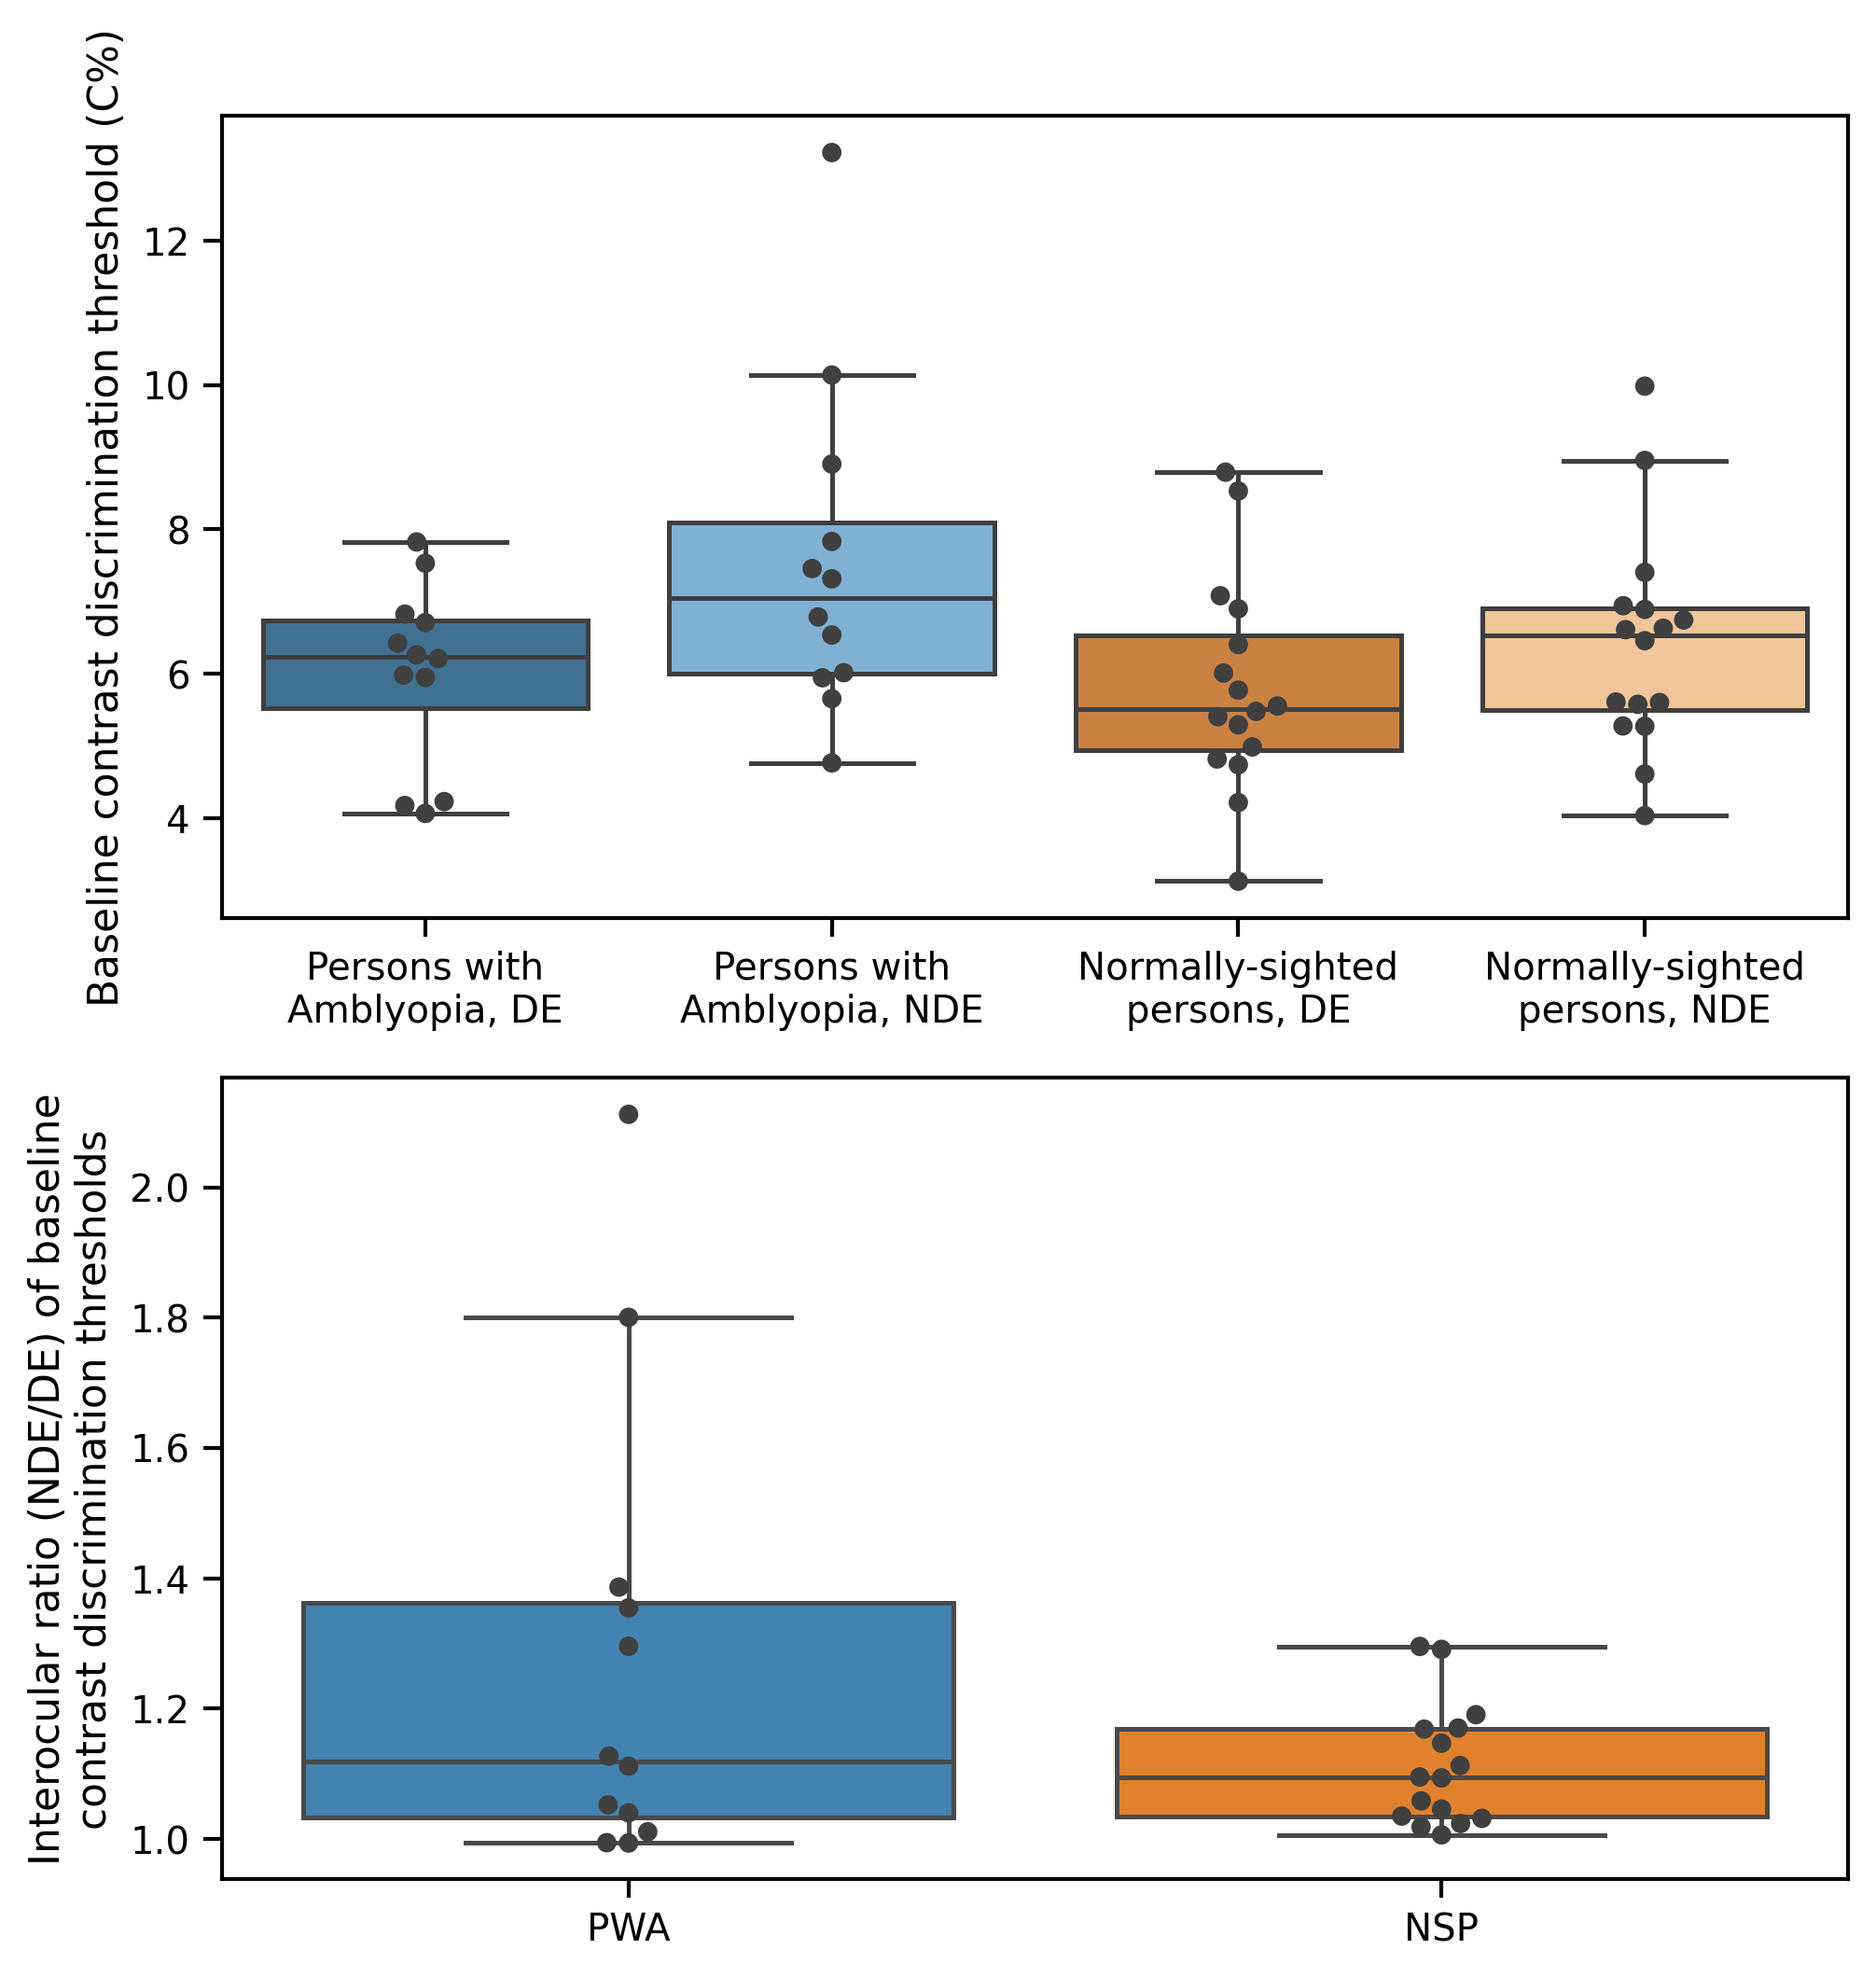

In [37]:
sns.set_context(context="paper", font_scale=1.1)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))#, gridspec_kw={"width_ratios":[2, 1]})
g = sns.boxplot(data=baseline_df_withinsubject,
                x='Trace',
                y='BaselineThresh',
                ax=ax[0],
                palette=pal4g,#["#aaaaaa"],
                fliersize=0) # fliersize=0 so outliers not drawn by boxplot()
g = sns.swarmplot(data=baseline_df_withinsubject,
                  x='Trace',
                  y='BaselineThresh',
                  ax=ax[0], color=".25")
g.set_xlabel('')
g.set_ylabel('Baseline contrast discrimination threshold (C%)')
print(baseline_df_withinsubject.groupby(['Population'])['Subject'].nunique())


g2 = sns.boxplot(data=baseline_df_withinsubject_diffs,
                 x='Population',
                 y='BaselineRatio',
                 ax=ax[1],
                 palette=colors2,#["#aaaaaa"],
                 fliersize=0)
g2 = sns.swarmplot(data=baseline_df_withinsubject_diffs,
                   x='Population',
                   y='BaselineRatio',
                   ax=ax[1],
                   color=".25")
g2.set_xlabel('')
g2.set_ylabel('Interocular ratio (NDE/DE) of baseline\ncontrast discrimination thresholds')
plt.subplots_adjust(left=.12, right=.95, top=.95, bottom=.05, hspace=.2)
print(baseline_df_withinsubject_diffs.groupby(['Population'])['Subject'].nunique())
fig.set_dpi(300)
fig.savefig(f"{plot_dir}/figure_08.pdf", dpi='figure')
plt.show()
plt.close('all')

In [38]:
def test_eye_diffs(g, col):
    ndes = g[g.Eye=='Nde'][['Subject',col]].sort_values(by=['Subject'])
    des = g[g.Eye=='De'][['Subject',col]].sort_values(by=['Subject'])
    diffs = g.groupby(['Subject']).apply(utils.get_interocular_diff, col).drop_duplicates(subset=['Subject','ValueRatio'])
    assert(ndes.Subject.array.equals(des.Subject.array))
    res = st.ttest_1samp(diffs['ValueRatio'], popmean=1)
    print(f"N=({len(ndes)}, {len(des)}, mean: {diffs['ValueRatio'].mean():.2f}, sem: {diffs['ValueRatio'].sem():.2f})\n1sample (NDE/DE): t={res.statistic:.2f}, p={res.pvalue:.2f}")
    print(f"Effect size: {((diffs['ValueRatio'].mean()-1)/diffs['ValueRatio'].std()):.2f}")
    return res, diffs

for gv, g in baseline_df_withinsubject.groupby(['Task','Orientation','Presentation']):
    print(gv)
    for gv2, g2 in g.groupby(['Population']):
        print(gv2)
        res, diffs = test_eye_diffs(g2, "BaselineThresh")

('SS', 'Iso', 'nDicho')
NSP
N=(16, 16, mean: 1.11, sem: 0.02)
1sample (NDE/DE): t=4.83, p=0.00
Effect size: 1.21
PWA
N=(12, 12, mean: 1.27, sem: 0.10)
1sample (NDE/DE): t=2.68, p=0.02
Effect size: 0.77


In [39]:
df_to_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809 entries, 0 to 969
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject                   809 non-null    object 
 1   Task                      809 non-null    object 
 2   Presentation              809 non-null    object 
 3   Orientation               809 non-null    object 
 4   Eye                       809 non-null    object 
 5   Population                809 non-null    object 
 6   MaskContrast              809 non-null    float64
 7   ThreshElev                809 non-null    float64
 8   ThreshElev_SE             809 non-null    float64
 9   RelMaskContrast           809 non-null    float64
 10  Trace                     809 non-null    object 
 11  BaselineThresh            809 non-null    float64
 12  BinCenterRelMaskContrast  809 non-null    float64
 13  BinNumber                 809 non-null    int64  
dtypes: float64

### GABA vs baseline contrast threshold

In [40]:
baseline_gaba_plot_df = df_to_model.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
simple_bg_df = baseline_gaba_plot_df.groupby(['Task','Orientation','Presentation','Population','Subject','Eye','Trace'])[['GABA','BaselineThresh']].agg(np.mean).reset_index()
simple_bg_df = simple_bg_df.rename(columns={"BaselineThresh":"value"})
simple_bg_df['measure'] = "BaselineThresh"
simple_bg_df.Trace = simple_bg_df.Trace.astype('category')
simple_bg_df.Trace.cat.reorder_categories(traces4, inplace=True)
simple_bg_df.Trace.cat.rename_categories(traces_graph4, inplace=True)
simple_bg_df.groupby(['Task','Orientation','Presentation','Population', 'Eye', 'measure'])['value'].describe(percentiles=[.5])

/tmp/ipykernel_89444/19644067.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  simple_bg_df.Trace.cat.reorder_categories(traces4, inplace=True)
/home/smerdis/anaconda3/envs/amblyopia/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


count      mean  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                 nMono        NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
     Iso         nDicho       NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                 nMono        NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   

                                                                  std    min  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                 nMono        NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
     Iso         nDicho       NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                 nMono        NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   

                                                                50%     max  
Task Orientation Presentation Population Eye measure                         
SS   Cross       nDicho       NSP        De  BaselineThresh  5.5150   8.794  
                                         Nde BaselineThresh  6.5345   9.987  
                              PWA        De  BaselineThresh  6.2360   7.827  
                                         Nde BaselineThresh  7.0515  13.226  
                 nMono        NSP        De  BaselineThresh  5.5150   8.794  
                                         Nde BaselineThresh  6.5345   9.987  
                              PWA        De  BaselineThresh  6.2360   7.827  
                                         Nde BaselineThresh  7.0515  13.226  
     Iso         nDicho       NSP        De  BaselineThresh  5.5150   8.794  
                                         Nde BaselineThresh  6.5345   9.987  
                              PWA        De  BaselineThresh  6.2360   7.827  
                                         Nde BaselineThresh  7.0515  13.226  
                 nMono        NSP        De  BaselineThresh  5.5150   8.794  
         

### Drop subjects without GABA

In [41]:
simple_bg_df_nonan = simple_bg_df[~np.isnan(simple_bg_df.GABA)]
simple_bg_df_nonan_onecond = (simple_bg_df_nonan[(simple_bg_df_nonan['Presentation']=='nDicho') & (simple_bg_df_nonan['Orientation']=='Iso')])

### Figure 11: GABA vs baseline contrast thresholds

In [42]:
%%time
bg_groups = simple_bg_df_nonan.groupby(['Task','Orientation','Presentation','measure'])
i = 0 # only do the first group since they're all the same
for gv, gr in bg_groups:
    if i==0:
        g = s.gaba_vs_psychophys_plot(gv, gr, legend=False,
                    log=True, ylim=(2.5, 16), truncate=False,
                    col="Population", col_order=["PWA", "NSP"], hue="Trace",
                    palette=pal4g,
                    n_boot=n_boot, legend_img=False,
                    markers=['o','d','o','d'],
                    aspect=1, facet_kws={'sharex':True, 'sharey':False})
        g.set_titles("")
        g.fig.subplots_adjust(left=.1, right=.95, bottom=0.1, wspace=0.15)
        g.fig.set_dpi(600)
        g.fig.set_size_inches((7,3.75))
        g.fig.savefig(f"{plot_dir}/figure_11.pdf", dpi="figure")
        plt.close('all')
        i = 1

('SS', 'Cross', 'nDicho', 'BaselineThresh')
nDicho

Percentiles for individual eye correlations:
Amb DE 
Observed value of -0.405 is greater than 0.147 of bootstrap distribution, corresponding to p=0.29.
Amb NDE 
Observed value of -0.275 is greater than 0.240 of bootstrap distribution, corresponding to p=0.48.
Con DE 
Observed value of 0.265 is greater than 0.825 of bootstrap distribution, corresponding to p=0.35.
Con NDE 
Observed value of 0.232 is greater than 0.786 of bootstrap distribution, corresponding to p=0.43.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of 0.129 is greater than 0.588 of bootstrap distribution, corresponding to p=0.82.
Con NDE vs DE 
Observed value of -0.033 is greater than 0.462 of bootstrap distribution, corresponding to p=0.92.
Pop Amb vs Con 
Observed value of 0.162 is greater than 0.599 of bootstrap distribution, corresponding to p=0.80.
[0.295 0.481 0.351 0.429], [0.823 0.923 0.802]

CPU times: user 38.8 s, sys: 2.1 s, total: 

## Plot and model the suppression data (RelMaskContrast vs ThreshElev)

In [43]:
# sns.relplot(data=df_to_model, x="MaskContrast", y="ThreshElev", hue="Trace",
#                         row="Orientation",
#                         #col="Population", col_order=["PWA", "NSP"],
#                         col="Presentation", col_order=["nMono", "nDicho"],
#                         palette=pal4, style="Eye", markers=['o','d'],
#                         height=4.5, aspect=1.3)\
#     .map(plt.axhline, y=1, linestyle='dotted', color='black')\
#     .set(ylabel="Threshold Elevation")\
#     .set(xlabel='Surround Contrast (C%)')
# plt.close('all')

In [44]:
# sns.relplot(data=df_to_model, x="RelMaskContrast", y="ThreshElev", hue="Trace",
#                         row="Orientation",
#                         #col="Population", col_order=["PWA", "NSP"],
#                         col="Presentation", col_order=["nMono", "nDicho"],
#                         palette=pal4, style="Eye", markers=['o','d'],
#                         height=4.5, aspect=1.3)\
# .map(plt.axhline, y=1, linestyle='dotted', color='black')\
# .map(plt.axvline, x=2, linestyle='dotted', color='grey')\
# .map(plt.axvline, x=5, linestyle='dotted', color='grey')\
# .map(plt.axvline, x=10, linestyle='dotted', color='grey')\
# .set(ylabel="Threshold Elevation")\
# .set(xlabel='Relative surround contrast\n (multiples of baseline)')
# plt.close('all')

## Pick critical value and observations closest to that

In [45]:
def closest_obs(df, col, to):
    co = (df.iloc[np.argmin(np.abs(df[col] - to))])
    return co

def annotate(data, field="hue", col="value", pos=(.05, .7), title=None, **kws):
    ax=plt.gca()
    annots = []
    for (i, (gv, g)) in enumerate(data.groupby(field)):
        pos_this=(pos[0], pos[1]+(.05*i))
        try:
            t, p = st.ttest_1samp(g[col], popmean=1)
            stat_annot = f"t({len(g)-1})={t:.2f}, p={p:.2f}"
            if title is not None:
                ax.text(*pos, title, transform=ax.transAxes, fontsize=11)
                pos_this=(pos[0], pos[1]+(.05*(i+1)))
        except KeyError as err:
            stat_annot = f"N={len(g)}"
            title = None
        if len(gv) == 1:
            annotation = f"{gv}: {stat_annot}"
        else:
            annotation = f"{' '.join(gv)}, {stat_annot}"
        annots.append(annotation)
        ax.text(*pos_this, annotation, transform=ax.transAxes, fontsize=11)

In [46]:
cv = 5
print(f"**Analysis at RelMaskContrast={cv}**\n")
final_obs = df_to_model.groupby(pp_gvars).apply(closest_obs, 'RelMaskContrast', cv).reset_index(drop=True)
sub_groups = final_obs.groupby(['Task','Orientation','Presentation','Population','Subject'], as_index=False)
xdiffs = sub_groups.apply(utils.get_interocular_diff, "RelMaskContrast").dropna().drop_duplicates(['Task','Orientation','Presentation','Subject','ValueDiff'])

# g1 = sns.catplot(kind='box', data=xdiffs, x='Population', y='ValueDiff', order=["PWA", "NSP"],
#             row="Orientation", row_order=["Iso", "Cross"],
#             col="Presentation", col_order=["nMono", "nDicho"],
#             height=4, aspect=1.1,
#             palette=colors2)\
#     .map_dataframe(annotate, field='Population', pos=(.7, .1))\
#     .set(ylabel=f"Interocular difference (Nde-De) of tested\nrelative surround contrasts at cv={cv}")
# g1.fig.subplots_adjust(wspace=.2, hspace=.2)
# plt.show()
# sns.relplot(data=final_obs, x="RelMaskContrast", y="ThreshElev", hue="Trace",
#             row="Orientation", row_order=["Iso", "Cross"],
#             col="Presentation", col_order=["nMono", "nDicho"],
#             palette=pal4, style="Eye", markers=['o','d'],
#             height=4.5, aspect=1.2)\
# .map(plt.axhline, y=1, linestyle='dotted', color='black')\
# .map(plt.axvline, x=cv, linestyle='dotted', color='grey')\
# .set(ylabel=f"Threshold Elevation\nat cv={cv}")\
# .set(xlabel='Relative surround contrast\n (multiples of baseline)')
# plt.show()
# plt.close('all')

**Analysis at RelMaskContrast=5**



In [47]:
final_obs_interocular = final_obs.groupby(['Task','Orientation','Presentation',
            'Population','Subject'],).apply(utils.get_interocular_diff, "ThreshElev").drop_duplicates(['Task','Orientation','Presentation','Subject','ValueDiff'])
final_obs_interocular

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,ValueDiff,ValueRatio
0,ai,SS,nDicho,Cross,De,NSP,30.0,0.874,0.009,4.321,Control-De,6.900,4.033,4,-0.096,0.890160
2,cr,SS,nDicho,Cross,De,NSP,30.0,1.262,0.009,7.438,Control-De,3.124,6.610,5,-0.616,0.511886
4,ct,SS,nDicho,Cross,De,NSP,30.0,1.284,0.008,3.349,Control-De,8.794,4.033,4,0.359,1.279595
6,dl,SS,nDicho,Cross,De,NSP,32.0,1.469,0.009,4.744,Control-De,5.772,4.033,4,-0.201,0.863172
8,ei,SS,nDicho,Cross,De,NSP,30.0,1.362,0.008,4.645,Control-De,4.985,4.033,4,-0.226,0.834068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,li,SS,nMono,Iso,De,PWA,18.0,1.233,0.006,4.431,Amblyope-De,4.063,4.556,4,-0.021,0.982968
216,mg,SS,nMono,Iso,De,PWA,10.0,0.841,0.006,2.396,Amblyope-De,4.174,2.637,3,0.064,1.076100
218,mv,SS,nMono,Iso,De,PWA,32.0,1.414,0.006,5.350,Amblyope-De,5.981,4.556,4,-0.099,0.929986
220,rn,SS,nMono,Iso,De,PWA,18.0,1.140,0.008,2.802,Amblyope-De,6.424,2.637,3,0.010,1.008772


In [48]:
final_obs_interocular[final_obs_interocular.Population=='PWA'].Subject.unique()

array(['am', 'bi', 'cl', 'eg', 'em', 'gd', 'jv', 'li', 'mg', 'mv', 'rn',
       'sd'], dtype=object)

### Table 3: ANOVA to look at effects and interactions

In [49]:
final_obs.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber
0,ai,SS,nDicho,Cross,De,NSP,30.0,0.874,0.009,4.321,Control-De,6.900,4.033,4
1,ai,SS,nDicho,Cross,Nde,NSP,30.0,0.778,0.009,4.348,Control-Nde,6.943,4.050,4
2,cr,SS,nDicho,Cross,De,NSP,30.0,1.262,0.009,7.438,Control-De,3.124,6.610,5
3,cr,SS,nDicho,Cross,Nde,NSP,10.0,0.646,0.005,3.201,Control-Nde,4.033,2.511,3
4,ct,SS,nDicho,Cross,De,NSP,30.0,1.284,0.008,3.349,Control-De,8.794,4.033,4


In [50]:
final_obs.groupby(['Orientation','Presentation','Population','Eye'])['ThreshElev'].describe()

count      mean       std    min  \
Orientation Presentation Population Eye                                     
Cross       nDicho       NSP        De    16.0  1.130500  0.252378  0.627   
                                    Nde   16.0  1.035813  0.303820  0.646   
                         PWA        De    12.0  0.921167  0.293242  0.416   
                                    Nde   12.0  1.742000  1.178050  0.680   
            nMono        NSP        De    16.0  0.897125  0.159301  0.608   
                                    Nde   16.0  0.782062  0.159986  0.481   
                         PWA        De    12.0  0.902167  0.237104  0.445   
                                    Nde   12.0  1.084417  0.251255  0.637   
Iso         nDicho       NSP        De    16.0  1.818750  0.664917  0.694   
                                    Nde   16.0  1.593687  0.585806  0.960   
                         PWA        De    12.0  0.979167  0.311035  0.473   
                                    Nde   12.0  2.252583  1.446894  0.824   
            nMono        NSP        De    16.0  1.269500  0.335953  0.671   
                                    Nde   16.0  1.205250  0.260729  0.866   
                         PWA        De    12.0  1.270500  0.481924  0.473   
                                    Nde   12.0  1.481000  0.441663  0.904   

                                             25%     50%      75%    max  
Orientation Presentation Population Eye                                   
Cross       nDicho       NSP        De   0.87325  1.2470  1.30350  1.469  
                                    Nde  0.77500  1.0150  1.17175  1.643  
                         PWA        De   0.74125  0.9370  1.02900  1.534  
                                    Nde  1.21525  1.3530  1.56250  4.893  
            nMono        NSP        De   0.80050  0.8990  0.97875  1.218  
                                    Nde  0.65400  0.8425  0.88800  1.084  
                         PWA        De   0.82950  0.9260  1.01375  1.386  
                                    Nde  0.90450  1.0955  1.22400  1.630  
Iso         nDicho       NSP        De   1.40475  1.7470  2.00175  3.428  
                                    Nde  1.05425  1.5405  1.78100  3.226  
                         PWA        De   0.70375  1.0340  1.17700  1.469  
                                    Nde  1.39975  2.1130  2.50125  6.129  
            nMono        NSP        De   1.04325  1.2980  1.50075  1.808  
                                    Nde  1.03650  1.1635  1.30075  1.703  
                         PWA        De   0.98125  1.2780  1.48425  2.259  
                                    Nde  1.15675  1.4240  1.85400  2.147

In [51]:
utils.big_anova(final_obs,
                "ThreshElev ~ C(Orientation) * C(Presentation) * C(Population) * C(Eye)")

,F,PR(>F)
C(Orientation),34.413000,1.735247e-08
C(Presentation),19.545764,1.581508e-05
C(Population),2.261026,1.341830e-01
C(Eye),6.941899,9.053605e-03
C(Orientation):C(Presentation),0.342167,5.592150e-01
C(Orientation):C(Population),1.398993,2.382425e-01
C(Presentation):C(Population),0.200318,6.549297e-01
C(Orientation):C(Eye),0.293808,5.883708e-01
C(Presentation):C(Eye),4.797062,2.961993e-02
C(Population):C(Eye),24.872343,1.289908e-06


In [52]:
utils.big_anova(final_obs_interocular,
                "ValueRatio ~ C(Orientation) * C(Presentation) * C(Population)")

,F,PR(>F)
C(Orientation),0.416006,5.203572e-01
C(Presentation),8.815647,3.707969e-03
C(Population),33.124504,8.801779e-08
C(Orientation):C(Presentation),0.050589,8.224830e-01
C(Orientation):C(Population),0.101032,7.512315e-01
C(Presentation):C(Population),13.235736,4.294229e-04
C(Orientation):C(Presentation):C(Population),0.639165,4.258355e-01
Residual,NaN,NaN


### Figure 9 and Table 4: Psychophysical results (Graphs and t-tests of NDE/DE ratio != 1)

In [53]:
def stat_annotate(data, field="hue", col="value", pos=(.05, .7), title=None, **kws):
    annots = {}
    for (i, (gv, g)) in enumerate(data.groupby(field)):
        try:
            t, p = st.ttest_1samp(g[col], popmean=1)
            stat_annot = f"t({len(g)-1})={t:.2f}\np={p:.2g}"
        except KeyError as err:
            stat_annot = f"N={len(g)}"
            title = None
        if len(gv) == 1:
            annotation_key = f"{gv}"
            annotation_text = f"{stat_annot}"
        else:
            annotation_key = f"{' '.join(gv)}"
            annotation_text = f"{stat_annot}"
        annots[annotation_key] = annotation_text
    return annots

In [54]:
final_obs_interocular.replace({'nDicho':'Dichoptic', 'nMono':'Monocular'}, inplace=True)
annots = stat_annotate(final_obs_interocular, field=["Orientation","Presentation", "Population"],
                   col="ValueRatio")
print(annots)

{'Cross Dichoptic NSP': 't(15)=-1.45\np=0.17', 'Cross Dichoptic PWA': 't(11)=2.38\np=0.036', 'Cross Monocular NSP': 't(15)=-2.48\np=0.026', 'Cross Monocular PWA': 't(11)=2.35\np=0.039', 'Iso Dichoptic NSP': 't(15)=-1.40\np=0.18', 'Iso Dichoptic PWA': 't(11)=3.42\np=0.0058', 'Iso Monocular NSP': 't(15)=0.11\np=0.92', 'Iso Monocular PWA': 't(11)=2.21\np=0.049'}


In [55]:
# graph_order = ['Cross Dichoptic PWA', 'Cross Dichoptic NSP', 'Cross Monocular PWA', 'Cross Monocular NSP', 
#                'Iso Dichoptic PWA', 'Iso Dichoptic NSP', 'Iso Monocular PWA', 'Iso Monocular NSP']
graph_order = ['Cross Dichoptic PWA', 'Cross Monocular PWA', 'Cross Dichoptic NSP', 'Cross Monocular NSP', 
               'Iso Dichoptic PWA', 'Iso Monocular PWA', 'Iso Dichoptic NSP', 'Iso Monocular NSP']

0 0 Cross Dichoptic PWA t(11)=2.38
p=0.036 Rectangle(xy=(-0.4, 0), width=0.4, height=2.17236, angle=0)
0 1 Cross Monocular PWA t(11)=2.35
p=0.039 Rectangle(xy=(0.6, 0), width=0.4, height=1.27535, angle=0)
0 2 Cross Dichoptic NSP t(15)=-1.45
p=0.17 Rectangle(xy=(-2.77556e-17, 0), width=0.4, height=0.926797, angle=0)
0 3 Cross Monocular NSP t(15)=-2.48
p=0.026 Rectangle(xy=(1, 0), width=0.4, height=0.884213, angle=0)
1 0 Iso Dichoptic PWA t(11)=3.42
p=0.0058 Rectangle(xy=(-0.4, 0), width=0.4, height=2.49412, angle=0)
1 1 Iso Monocular PWA t(11)=2.21
p=0.049 Rectangle(xy=(0.6, 0), width=0.4, height=1.25508, angle=0)
1 2 Iso Dichoptic NSP t(15)=-1.40
p=0.18 Rectangle(xy=(-2.77556e-17, 0), width=0.4, height=0.912239, angle=0)
1 3 Iso Monocular NSP t(15)=0.11
p=0.92 Rectangle(xy=(1, 0), width=0.4, height=1.00891, angle=0)


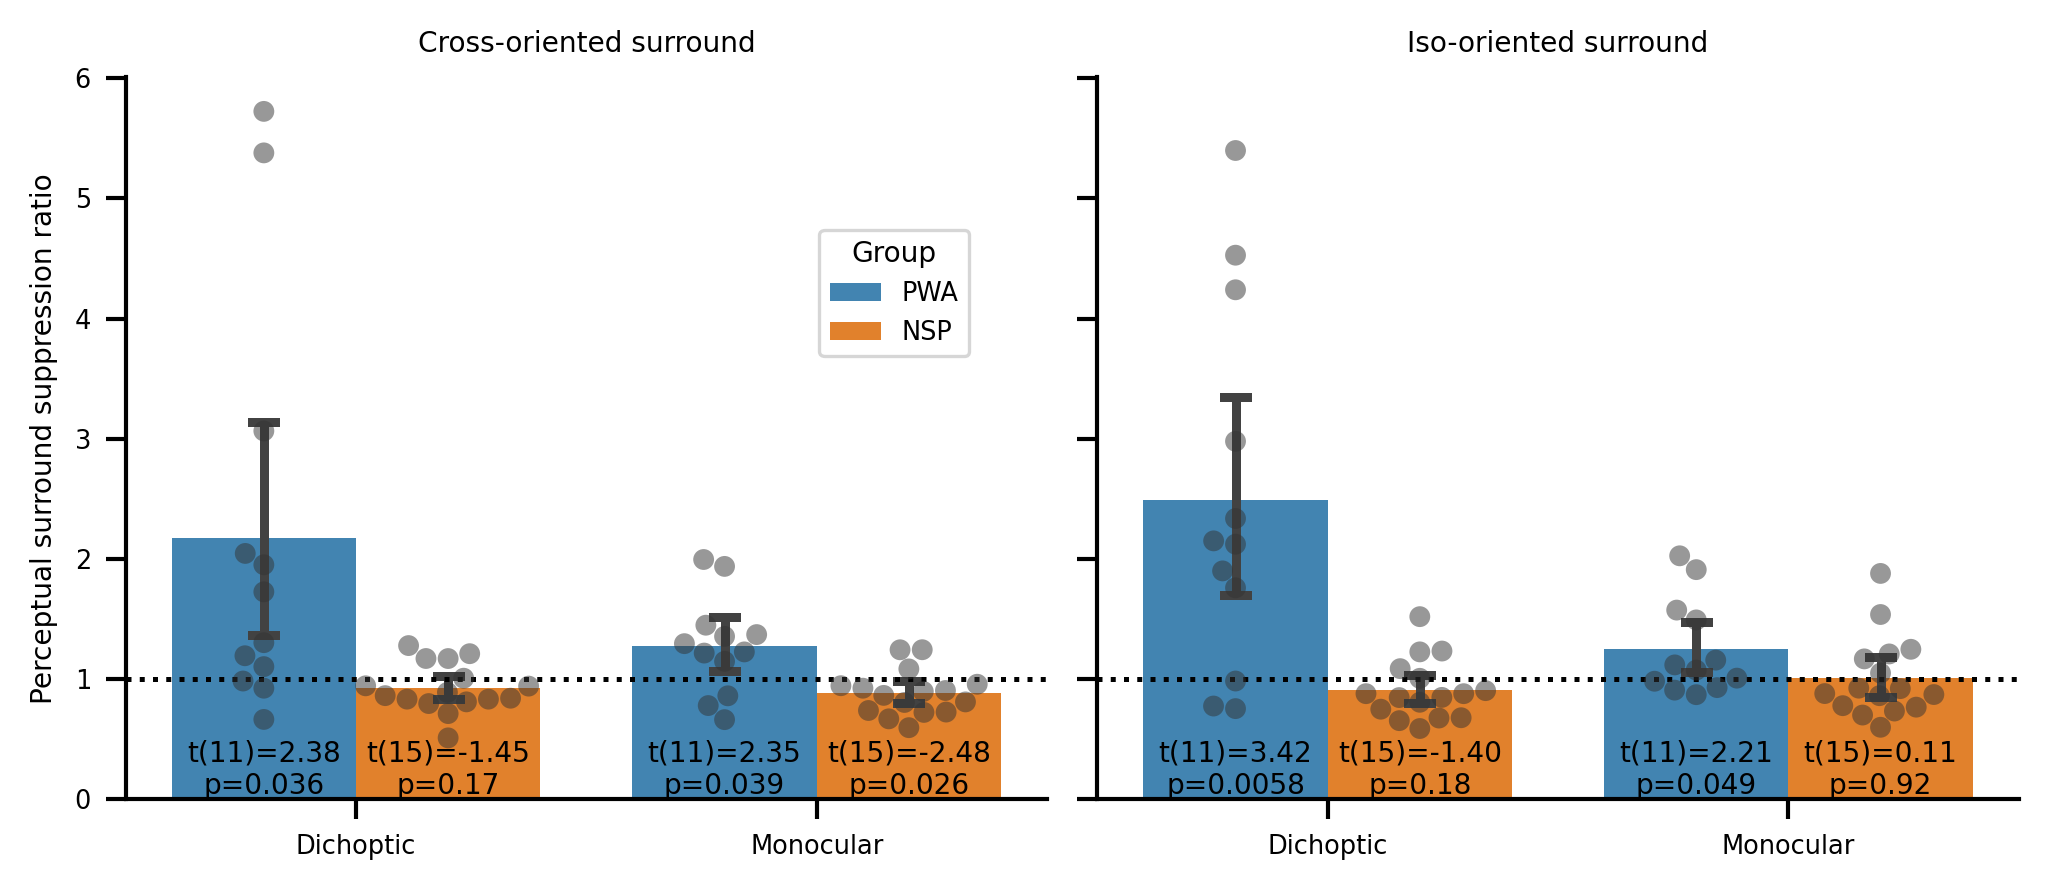

In [56]:
with sns.plotting_context(context="paper", font_scale=0.7):
    g = sns.catplot(data=final_obs_interocular, kind='bar',
                x="Presentation", y="ValueRatio", col="Orientation",
                    hue="Population", hue_order=["PWA","NSP"], capsize=0.05,
                    palette=colors2, aspect=1.1, legend_out=False, height=3.1)
    g = g.map_dataframe(sns.swarmplot, x="Presentation", y="ValueRatio",
                    hue="Population", hue_order=["PWA","NSP"], dodge=True,
                    palette=["#333333"], alpha=0.5)
    g = g.map(plt.axhline, y=1, linestyle="dotted", color="black")
    g.set_titles("{col_name}-oriented surround")
    g.set_axis_labels("", "Perceptual surround suppression ratio")

    hue_labels = ["PWA", "NSP"]
    for i, ax in enumerate(g.axes.ravel()):
        for j, p in enumerate(ax.patches):
            print(i, j, graph_order[4*i+j], annots[graph_order[4*i+j]], p)
            ax.annotate(f"{annots[graph_order[4*i+j]]}", ha="center", va="center", xy=(p.get_x()+ p.get_width() / 2., p.get_y() + 0.25))

    g._legend.set_title("Group")       
    sns.move_legend(g, (0.4, 0.6))
    g.fig.set_dpi(300)
    g.fig.savefig(f"{plot_dir}/figure_09.pdf", dpi='figure')

In [57]:
amb_data

,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA,GABA
0,1,ac,AC_081714,36,2,male,1,PWA,4,1,...,2,right,iodAcuity,0,-0.204120,0.116910,0.321030,0.198,0.215,0.092
2,6,as,AS_071814,39,1,female,1,PWA,3,1,...,1,left,iodAcuity,0,-0.097000,0.244000,0.341000,0.217,0.196,0.100
3,7,bi,BI_050514,52,1,female,1,PWA,3,1,...,2,right,iodAcuity,0,-0.096910,0.417940,0.514850,0.205,0.219,0.095
4,9,ch,CH_072314,33,1,female,1,PWA,3,2,...,1,left,iodAcuity,0,-0.084939,1.176091,1.261030,0.184,NaN,0.086
6,12,cs,CS_072714,46,2,male,1,PWA,4,1,...,2,right,iodAcuity,0,-0.096910,0.281030,0.377940,0.220,NaN,0.102
10,17,em,EM_060714,61,1,female,1,PWA,3,1,...,1,left,iodAcuity,0,-0.096910,0.497121,0.594031,0.185,0.215,0.087
11,19,gd,GD_052014,50,1,female,1,PWA,3,1,...,1,left,iodAcuity,0,-0.164000,0.398000,0.562000,0.197,0.208,0.092
14,24,jv,JV_050514,19,2,male,1,PWA,4,1,...,2,right,iodAcuity,0,-0.085000,0.538000,0.623000,0.201,0.205,0.094
15,26,ks,KS_072014,44,1,female,1,PWA,3,1,...,1,left,iodAcuity,0,-0.204000,0.261000,0.465000,0.207,0.211,0.097
17,28,li,LI_081514,25,2,male,1,PWA,4,2,...,1,left,iodAcuity,0,0.000000,0.224000,0.224000,0.216,NaN,0.100


In [58]:
final_obs_interocular.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 0 to 222
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject                   112 non-null    object 
 1   Task                      112 non-null    object 
 2   Presentation              112 non-null    object 
 3   Orientation               112 non-null    object 
 4   Eye                       112 non-null    object 
 5   Population                112 non-null    object 
 6   MaskContrast              112 non-null    float64
 7   ThreshElev                112 non-null    float64
 8   ThreshElev_SE             112 non-null    float64
 9   RelMaskContrast           112 non-null    float64
 10  Trace                     112 non-null    object 
 11  BaselineThresh            112 non-null    float64
 12  BinCenterRelMaskContrast  112 non-null    float64
 13  BinNumber                 112 non-null    int64  
 14  ValueDiff 

In [59]:
amb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 25
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   numID         14 non-null     int64  
 1   initials      14 non-null     object 
 2   scanID        14 non-null     object 
 3   age           14 non-null     int64  
 4   sex           14 non-null     int64  
 5   labelSex      14 non-null     object 
 6   group         14 non-null     int64  
 7   labelGroup    14 non-null     object 
 8   sexGroupNum   14 non-null     int64  
 9   ambType       14 non-null     int64  
 10  labelAmbType  14 non-null     object 
 11  hasSS         14 non-null     int64  
 12  nde           14 non-null     int64  
 13  labelNDE      14 non-null     object 
 14  originNDE     14 non-null     object 
 15  swapNDE_EY    14 non-null     int64  
 16  acuityDE      14 non-null     float64
 17  acuityNDE     14 non-null     float64
 18  iadLogMAR     14 non-null     fl

In [60]:
amb_data

,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA,GABA
0,1,ac,AC_081714,36,2,male,1,PWA,4,1,...,2,right,iodAcuity,0,-0.204120,0.116910,0.321030,0.198,0.215,0.092
2,6,as,AS_071814,39,1,female,1,PWA,3,1,...,1,left,iodAcuity,0,-0.097000,0.244000,0.341000,0.217,0.196,0.100
3,7,bi,BI_050514,52,1,female,1,PWA,3,1,...,2,right,iodAcuity,0,-0.096910,0.417940,0.514850,0.205,0.219,0.095
4,9,ch,CH_072314,33,1,female,1,PWA,3,2,...,1,left,iodAcuity,0,-0.084939,1.176091,1.261030,0.184,NaN,0.086
6,12,cs,CS_072714,46,2,male,1,PWA,4,1,...,2,right,iodAcuity,0,-0.096910,0.281030,0.377940,0.220,NaN,0.102
10,17,em,EM_060714,61,1,female,1,PWA,3,1,...,1,left,iodAcuity,0,-0.096910,0.497121,0.594031,0.185,0.215,0.087
11,19,gd,GD_052014,50,1,female,1,PWA,3,1,...,1,left,iodAcuity,0,-0.164000,0.398000,0.562000,0.197,0.208,0.092
14,24,jv,JV_050514,19,2,male,1,PWA,4,1,...,2,right,iodAcuity,0,-0.085000,0.538000,0.623000,0.201,0.205,0.094
15,26,ks,KS_072014,44,1,female,1,PWA,3,1,...,1,left,iodAcuity,0,-0.204000,0.261000,0.465000,0.207,0.211,0.097
17,28,li,LI_081514,25,2,male,1,PWA,4,2,...,1,left,iodAcuity,0,0.000000,0.224000,0.224000,0.216,NaN,0.100


In [61]:
supp_vs_iad_groups = final_obs_interocular.groupby(['Task', 'Orientation', 'Presentation', 'Population'])
for gv, g in supp_vs_iad_groups:
    if 'PWA' in gv:
        g2 = g.join(amb_data.set_index('initials')['iadLogMAR'], on='Subject').dropna()
        print(gv, g2.loc[:, ['Subject', 'ValueRatio', 'iadLogMAR']])
        print(st.spearmanr(g2['ValueRatio'], g2['iadLogMAR']))

('SS', 'Cross', 'Dichoptic', 'PWA')    Subject  ValueRatio  iadLogMAR
34      bi    1.726580   0.514850
40      em    5.377634   0.594031
42      gd    1.195000   0.562000
44      jv    0.925033   0.623000
46      li    1.303810   0.224000
48      mg    0.665362   0.582000
52      rn    2.046053   0.525150
54      sd    1.951825   0.832790
SpearmanrResult(correlation=0.0, pvalue=1.0)
('SS', 'Cross', 'Monocular', 'PWA')     Subject  ValueRatio  iadLogMAR
90       bi    1.226964   0.514850
96       em    1.448980   0.594031
98       gd    1.217262   0.562000
100      jv    0.780664   0.623000
102      li    0.861742   0.224000
104      mg    0.663542   0.582000
108      rn    1.295561   0.525150
110      sd    1.938169   0.832790
SpearmanrResult(correlation=0.2380952380952381, pvalue=0.5701563208157683)
('SS', 'Iso', 'Dichoptic', 'PWA')     Subject  ValueRatio  iadLogMAR
146      bi    2.336745   0.514850
152      em    4.238908   0.594031
154      gd    2.978687   0.562000
156      jv  

### Figure 3, the modeling example

In [62]:
onecond = df_to_model[(df_to_model.Orientation=="Iso") & (df_to_model.Presentation=="nDicho")]
onecond_onesub = onecond[(onecond.Subject == 'ai') | (onecond.Subject=="am")]
ns_onecond = onecond.groupby(['Task','Orientation','Presentation','Population','Eye','Trace'])['Subject'].nunique().reset_index()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 6.5), dpi=300)

ax1.axhline(y=1, linestyle='dotted', color='grey')
sns.scatterplot(data=onecond, ax=ax1, x="MaskContrast", y="ThreshElev",
                color=".4", legend=False, marker='.')
sns.scatterplot(data=onecond_onesub, ax=ax1, x="MaskContrast", y="ThreshElev",
                hue="Trace", palette=pal4, legend=False)
ax1.set(ylabel="Relative contrast\ndiscrimination threshold")
ax1.set(xlabel='Surround Contrast')

ax2.axhline(y=1, linestyle='dotted', color='grey')
ax2.axvline(x=5, linestyle='dotted', color='black')
sns.scatterplot(data=onecond, ax=ax2, x="RelMaskContrast", y="ThreshElev",
                #hue="Trace", palette=pal4
                color=".4", legend=False, marker='.')
sns.scatterplot(data=onecond_onesub, ax=ax2, x="RelMaskContrast", y="ThreshElev",
                hue="Trace", palette=pal4, legend=False)
ax2.set(ylabel="Relative contrast\ndiscrimination threshold")
ax2.set(xlabel='Relative surround contrast\n (multiples of baseline)')


final_obs_onecond = onecond.groupby(pp_gvars).apply(closest_obs, 'RelMaskContrast', cv).reset_index(drop=True)
final_obs_onecond_onesub = onecond_onesub.groupby(pp_gvars).apply(closest_obs, 'RelMaskContrast', cv).reset_index(drop=True)


ax3.axhline(y=1, linestyle='dotted', color='grey')
ax3.axvline(x=5, linestyle='dotted', color='black')
sns.scatterplot(data=final_obs_onecond, ax=ax3, x="RelMaskContrast", y="ThreshElev",
                #hue="Trace",
                color=".4", marker=".", legend=False)
sns.scatterplot(data=final_obs_onecond_onesub, ax=ax3, x="RelMaskContrast", y="ThreshElev",
                hue="Trace", palette=pal4, legend="brief")

ax3.legend_.set_visible(False)
ax3.set(xlim=ax2.get_xlim())
ax3.set(ylabel="Relative contrast\ndiscrimination threshold")
ax3.set(xlabel='Relative surround contrast\n (multiples of baseline)')

handles, labels = ax3.get_legend_handles_labels()
h_leg = []
l_leg = []
for (h, l) in zip(handles, labels):
    if l in traces4:
        i = traces4.index(l)
        n = ns_onecond[ns_onecond.Trace==l]['Subject'].iloc[0]
        print(h, l, i, n, traces_graph4[i])
        h_leg.append(h)
        l_leg.append(f"{traces_graph4[i]}\n(N={n})")

fig.legend(h_leg, l_leg, loc='center right')
#fig.legend(pal4g)
fig.subplots_adjust(hspace=.6, right=.7)
plt.savefig(f"{plot_dir}/figure_03.pdf", dpi='figure')
plt.close('all')

<matplotlib.collections.PathCollection object at 0x7fc187aa9a30> Control-De 2 16 Normally-sighted
persons, DE
<matplotlib.collections.PathCollection object at 0x7fc187aa91f0> Control-Nde 3 16 Normally-sighted
persons, NDE
<matplotlib.collections.PathCollection object at 0x7fc187aa3940> Amblyope-De 0 12 Persons with
Amblyopia, DE
<matplotlib.collections.PathCollection object at 0x7fc187ab7520> Amblyope-Nde 1 12 Persons with
Amblyopia, NDE


## Subset to include only (GABA and psychophysics) subjects

In [63]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [64]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.\n{gaba_and_pp_subjs_thistask}")

Of the 24 subjects with both GABA and psychophysics data, 23 have both for task SS.
['ai' 'am' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw'
 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']


### Remove subjects we don't have data on both GABA/PP for

In [65]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
amb_subjs = (gdf[gdf.Population=='PWA'])
nsp_subjs = (gdf[gdf.Population=="NSP"])
print(f'Of the {len(gdf)} subjects with GABA and {task} data, {len(amb_subjs)} are PWA.')
n_this_task = len(gdf)

Of the 22 subjects with GABA and SS data, 8 are PWA.


In [66]:
comb = final_obs.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
comb.drop_duplicates(inplace=True)
comb = comb.join(demos.set_index('initials')['motorGABA'], on='Subject')
comb.drop_duplicates(inplace=True)

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]
print(len(comb), len(comb_gabappsub))
comb_gabappsub.Subject.unique()

224 176


array(['ai', 'cr', 'ct', 'dl', 'ei', 'es', 'gm', 'jd', 'kw', 'ls', 'mk',
       'ms', 'nl', 'yl', 'bi', 'em', 'gd', 'jv', 'li', 'mg', 'rn', 'sd'],
      dtype=object)

In [67]:
baz = pd.melt(comb, id_vars=(pp_gvars + ['RelMaskContrast','BaselineThresh','GABA', 'motorGABA']),
              value_vars=["ThreshElev"], var_name='measure')
baz.dropna(subset=['GABA'], inplace=True)
baz.Trace = baz.Trace.astype('category')
baz_temp = baz.Trace.copy()
baz.Trace.cat.reorder_categories(traces4, inplace=True)
assert(baz_temp.equals(baz.Trace))
baz.Trace.cat.rename_categories(traces_graph4, inplace=True)

/tmp/ipykernel_89444/2954738275.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  baz.Trace.cat.reorder_categories(traces4, inplace=True)
/home/smerdis/anaconda3/envs/amblyopia/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


### Figures 4 and 5: GABA vs perceptual suppression

In [68]:
quux = baz.copy() # will use this struct for motorGABA, baz for occipital gaba as previously
quux = quux.dropna(axis=0, subset=['motorGABA'])
#quux['GABA'] = quux['motorGABA'] # overwrite the GABA column to reuse the old code below that refers to 'GABA'
quux

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,RelMaskContrast,BaselineThresh,GABA,motorGABA,measure,value
0,SS,Cross,nDicho,NSP,ai,De,"Normally-sighted\npersons, DE",4.321,6.900,0.103,0.236,ThreshElev,0.874
1,SS,Cross,nDicho,NSP,ai,Nde,"Normally-sighted\npersons, NDE",4.348,6.943,0.103,0.236,ThreshElev,0.778
2,SS,Cross,nDicho,NSP,cr,De,"Normally-sighted\npersons, DE",7.438,3.124,0.094,0.204,ThreshElev,1.262
3,SS,Cross,nDicho,NSP,cr,Nde,"Normally-sighted\npersons, NDE",3.201,4.033,0.094,0.204,ThreshElev,0.646
4,SS,Cross,nDicho,NSP,ct,De,"Normally-sighted\npersons, DE",3.349,8.794,0.097,0.208,ThreshElev,1.284
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,SS,Iso,nMono,PWA,jv,Nde,"Persons with\nAmblyopia, NDE",8.186,4.764,0.094,0.205,ThreshElev,1.968
216,SS,Iso,nMono,PWA,mg,De,"Persons with\nAmblyopia, DE",2.396,4.174,0.101,0.227,ThreshElev,0.841
217,SS,Iso,nMono,PWA,mg,Nde,"Persons with\nAmblyopia, NDE",5.660,5.654,0.101,0.227,ThreshElev,0.905
220,SS,Iso,nMono,PWA,rn,De,"Persons with\nAmblyopia, DE",2.802,6.424,0.093,0.210,ThreshElev,1.140


In [69]:
quux.motorGABA.isna().any()

False

In [70]:
%%time
for (y, df) in [('GABA', baz), ('motorGABA', quux)]:
    print(f"***{y} vs perceptual suppression:***")
    #print(df.head())
    fig_groups = df.replace({"nDicho":"Dichoptic", "nMono":"Monocular"}).groupby(['Task', 'Orientation', 'measure'])
    for fgv, fg in fig_groups:
        #print(fg)
        assert(fg['Orientation'].nunique()==1) # we're only looking at one surround orientation per figure
        o = fg['Orientation'].iloc[0] # first element can be used for all
        if o=="Cross":
            outfile = f"{plot_dir}/figure_04_{y}.pdf"
            ylim = (0.2, 4)
        elif o=="Iso":
            outfile = f"{plot_dir}/figure_05_{y}.pdf"
            ylim = (0.2, 6)
        else:
            # problem
            raise Error
        g = s.gaba_vs_psychophys_plot(fgv, fg, 
                    legend_img = False,
                    legend = False,
                    log = True,
                    truncate=False,
                    ylim = ylim,
                    row="Presentation", row_order=["Dichoptic", "Monocular"],
                    col="Population", col_order=["PWA","NSP"],
                    hue="Trace",
                    palette=pal4g,
                    annotate=True, boot_func=utils.compare_rs,
                    n_boot=n_boot,
                    markers=['o','d','o','d'],
                    facet_kws={'sharex':True, 'sharey':False})
        g.set_titles('{row_name}, {col_name}') # top row is dichoptic
        print(g.fig.get_size_inches(), g.fig.get_dpi())
        g.fig.subplots_adjust(left=.1, right=.95, bottom=0.06, hspace=.2, top=.95, wspace=0.15)
        g.fig.set_dpi(1200)
        g.fig.set_size_inches((7,7))
        g.fig.savefig(outfile, dpi='figure')
        plt.close('all')

***GABA vs perceptual suppression:***
('SS', 'Cross', 'ThreshElev')
Dichoptic

Percentiles for individual eye correlations:
Amb DE 
Observed value of 0.731 is greater than 0.976 of bootstrap distribution, corresponding to p=0.05.
Amb NDE 
Observed value of -0.299 is greater than 0.228 of bootstrap distribution, corresponding to p=0.46.
Con DE 
Observed value of 0.056 is greater than 0.573 of bootstrap distribution, corresponding to p=0.85.
Con NDE 
Observed value of 0.158 is greater than 0.709 of bootstrap distribution, corresponding to p=0.58.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of -1.030 is greater than 0.026 of bootstrap distribution, corresponding to p=0.05.
Con NDE vs DE 
Observed value of 0.102 is greater than 0.603 of bootstrap distribution, corresponding to p=0.79.
Pop Amb vs Con 
Observed value of -1.132 is greater than 0.043 of bootstrap distribution, corresponding to p=0.09.
[0.049 0.455 0.854 0.583], [0.052 0.795 0.086]

Monocular

Perce

# Orientation-selective surround suppression analysis

In [71]:
oss_gvars = ["Task", "Presentation", "Population", "Subject", "Eye", "Trace"]#, "GABA"]
oss_gvars_combeyes = ["Task", "Presentation", "Population", "Subject", "Trace"]#, "GABA"]
oss_df_gaba = baz.groupby(oss_gvars + ['GABA']).apply(utils.calculate_orientation_selective_suppression).reset_index().dropna()
oss_df = final_obs.groupby(oss_gvars).apply(utils.calculate_orientation_selective_suppression, col='ThreshElev').reset_index().dropna()
oss_df['measure'] = 'OSSSRatio'

In [72]:
oss_df.groupby(['Task', 'Presentation', 'Population','Eye'])['value'].agg(['mean', 'sem'])

mean       sem
Task Presentation Population Eye                    
SS   nDicho       NSP        De   1.608720  0.115064
                             Nde  1.549659  0.087678
                  PWA        De   1.083988  0.072228
                             Nde  1.383720  0.177610
     nMono        NSP        De   1.427882  0.087824
                             Nde  1.562478  0.065940
                  PWA        De   1.381474  0.077995
                             Nde  1.362341  0.069941

## Figure 10: OSSS results (two-tailed 1-sample  t-tests)

{'Dichoptic NSP DE': 't(15)=5.29\np=9.1e-05', 'Dichoptic NSP NDE': 't(15)=6.27\np=1.5e-05', 'Dichoptic PWA DE': 't(11)=1.16\np=0.27', 'Dichoptic PWA NDE': 't(11)=2.16\np=0.054', 'Monocular NSP DE': 't(15)=4.87\np=0.0002', 'Monocular NSP NDE': 't(15)=8.53\np=3.9e-07', 'Monocular PWA DE': 't(11)=4.89\np=0.00048', 'Monocular PWA NDE': 't(11)=5.18\np=0.0003'}
4
0 0 Dichoptic NSP DE t(15)=5.29
p=9.1e-05 Rectangle(xy=(-0.4, 0), width=0.4, height=1.60872, angle=0)
0 1 Dichoptic PWA DE t(11)=1.16
p=0.27 Rectangle(xy=(0.6, 0), width=0.4, height=1.08399, angle=0)
0 2 Dichoptic NSP NDE t(15)=6.27
p=1.5e-05 Rectangle(xy=(-2.77556e-17, 0), width=0.4, height=1.54966, angle=0)
0 3 Dichoptic PWA NDE t(11)=2.16
p=0.054 Rectangle(xy=(1, 0), width=0.4, height=1.38372, angle=0)
4
1 0 Monocular NSP DE t(15)=4.87
p=0.0002 Rectangle(xy=(-0.4, 0), width=0.4, height=1.42788, angle=0)
1 1 Monocular PWA DE t(11)=4.89
p=0.00048 Rectangle(xy=(0.6, 0), width=0.4, height=1.38147, angle=0)
1 2 Monocular NSP NDE t(15)

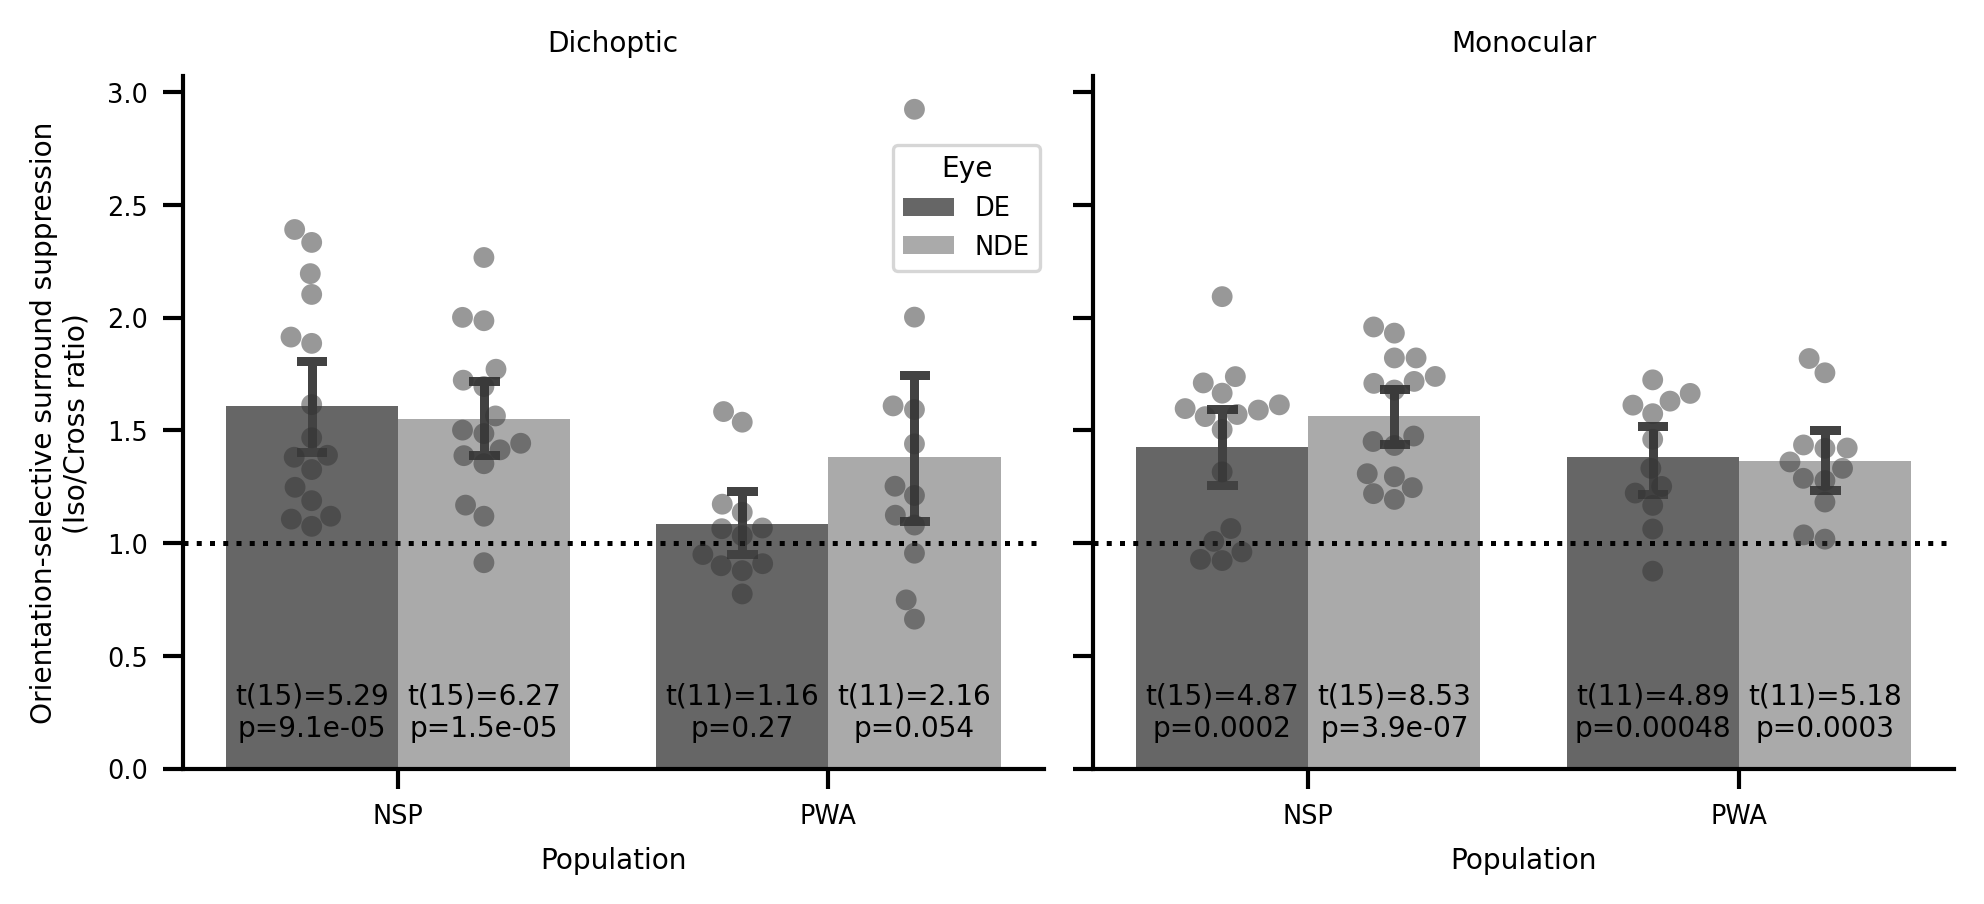

In [73]:
with sns.plotting_context(context="paper", font_scale=0.7):
    oss_df.replace({"nDicho":"Dichoptic", "nMono":"Monocular", "Nde":"NDE", "De":"DE"}, inplace=True)
    osss_annots = stat_annotate(oss_df, field=["Presentation","Population","Eye"],
                       col="value")
    print(osss_annots)
    g = sns.catplot(data=oss_df, kind='bar', x='Population', y='value', hue='Eye',
                col='Presentation', capsize=0.05, legend_out=False,
                palette=["#666666", "#aaaaaa"], height=3, aspect=1.1).map_dataframe(sns.swarmplot,
                    x="Population", y="value",
                    hue="Eye", dodge=True, palette=["#333333"], alpha=0.5)
    g = g.map(plt.axhline, y=1, linestyle="dotted", color="black")

    graph_order = ['Dichoptic NSP DE', 'Dichoptic PWA DE', 'Dichoptic NSP NDE', 'Dichoptic PWA NDE', 
                   'Monocular NSP DE', 'Monocular PWA DE', 'Monocular NSP NDE', 'Monocular PWA NDE']

    for i, ax in enumerate(g.axes.ravel()):
        print(len(ax.patches))
        for j, p in enumerate(ax.patches):
            print(i, j, graph_order[4*i+j], osss_annots[graph_order[4*i+j]], p)
            ax.annotate(f"{osss_annots[graph_order[4*i+j]]}", ha="center", va="center", xy=(p.get_x()+ p.get_width() / 2., p.get_y() + 0.25))

    sns.move_legend(g, (0.45, 0.7))

    # g = g.map_dataframe(annotate, field=["Population", "Eye"], col="value", pos=(.22, .77),
    #                    title=fr"T-tests of OSSS ratio $\neq$ 1")
    g.set_titles("{col_name}")
    g.set_ylabels("Orientation-selective surround suppression\n(Iso/Cross ratio)")
    g.fig.subplots_adjust(left=.09)
    g.fig.set_dpi(300)
    g.fig.savefig(f"{plot_dir}/figure_10.pdf", dpi='figure')

In [74]:
for gv, g in oss_df.groupby(['Task', 'Presentation', 'Population','Eye']):
    print(gv)
    ttres = st.ttest_1samp(g['value'], popmean=1, nan_policy='omit')
    print(f"N = {len(g)}, mean Iso/Cross ratio: {g['value'].mean():.2f}, t={ttres.statistic:.2f}, p={ttres.pvalue}")

('SS', 'Dichoptic', 'NSP', 'DE')
N = 16, mean Iso/Cross ratio: 1.61, t=5.29, p=9.070926667930878e-05
('SS', 'Dichoptic', 'NSP', 'NDE')
N = 16, mean Iso/Cross ratio: 1.55, t=6.27, p=1.5037184430919884e-05
('SS', 'Dichoptic', 'PWA', 'DE')
N = 12, mean Iso/Cross ratio: 1.08, t=1.16, p=0.2695101513990171
('SS', 'Dichoptic', 'PWA', 'NDE')
N = 12, mean Iso/Cross ratio: 1.38, t=2.16, p=0.053661004493975206
('SS', 'Monocular', 'NSP', 'DE')
N = 16, mean Iso/Cross ratio: 1.43, t=4.87, p=0.0002031346818837806
('SS', 'Monocular', 'NSP', 'NDE')
N = 16, mean Iso/Cross ratio: 1.56, t=8.53, p=3.873447169226604e-07
('SS', 'Monocular', 'PWA', 'DE')
N = 12, mean Iso/Cross ratio: 1.38, t=4.89, p=0.0004784452869538442
('SS', 'Monocular', 'PWA', 'NDE')
N = 12, mean Iso/Cross ratio: 1.36, t=5.18, p=0.0003034431311345164


#### GABA vs OSSS

In [75]:
for gv, g in oss_df_gaba.groupby(['Task', 'Presentation', 'Population','Eye']):
    print(gv)
    print(st.spearmanr(g['GABA'], g['value']), "\n")

('SS', 'nDicho', 'NSP', 'De')
SpearmanrResult(correlation=0.10804910262127791, pvalue=0.7131198549980806) 

('SS', 'nDicho', 'NSP', 'Nde')
SpearmanrResult(correlation=0.2601998797818529, pvalue=0.36895852297625276) 

('SS', 'nDicho', 'PWA', 'De')
SpearmanrResult(correlation=-0.03592878785739777, pvalue=0.932691474909088) 

('SS', 'nDicho', 'PWA', 'Nde')
SpearmanrResult(correlation=0.02395252523826518, pvalue=0.9551061898789129) 

('SS', 'nMono', 'NSP', 'De')
SpearmanrResult(correlation=-0.07717793044376993, pvalue=0.7931362290284194) 

('SS', 'nMono', 'NSP', 'Nde')
SpearmanrResult(correlation=-0.23373887505827468, pvalue=0.42124349937537175) 

('SS', 'nMono', 'PWA', 'De')
SpearmanrResult(correlation=-0.34731161595484505, pvalue=0.3992638742032819) 

('SS', 'nMono', 'PWA', 'Nde')
SpearmanrResult(correlation=0.467074242146171, pvalue=0.24326991663399547) 

